## ウエハサイズを限定せずに機械学習させる

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import csv

import pickle
import copy
import cv2
import random
import glob

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)
import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend.tensorflow_backend as tfback


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


Using TensorFlow backend.


['LSWMD.pkl']


In [3]:
# Define
max_size = 200
encord_size = int(max_size / 2)

MAKE_DATASET = True
TRAIN_AUTO_ENCODER = True

auto_encoder_path = './model/ae_' + str(max_size) + '.h5'

### データについて

In [4]:
if MAKE_DATASET:
    df=pd.read_pickle("../input/LSWMD.pkl")

    df = df.drop(['waferIndex'], axis = 1)

    def find_dim(x):
        dim0=np.size(x,axis=0)
        dim1=np.size(x,axis=1)
        return dim0,dim1
    df['waferMapDim']=df.waferMap.apply(find_dim)

In [5]:
if MAKE_DATASET:
    df['failureNum']=df.failureType
    df['trainTestNum']=df.trianTestLabel
    mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
    mapping_traintest={'Training':0,'Test':1}
    df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

    tol_wafers = df.shape[0]

    df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
    df_withlabel =df_withlabel.reset_index()
    df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
    df_withpattern = df_withpattern.reset_index()
    df_nonpattern = df[(df['failureNum']==8)]

### データサイズ関係なく処理

- 使えるデータサイズを求める
    - ラベル付きのデータすべて

In [6]:
if MAKE_DATASET:
    uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
    wdim = uni_waferDim[0]
    failure_list = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'none']
    usable_wdim_list = []
    usable_wafer_num = 0
    for i in range(len(wdim)):
        if wdim[i][0] > max_size or wdim[i][1] > max_size:
            continue
        sub_df = df.loc[df['waferMapDim'] == wdim[i]]
        pattern_num = [0] * 9
        for j in range(len(sub_df)):
            if len(sub_df.iloc[j,:]['failureType']) == 0:
                continue
            pattern = sub_df.iloc[j,:]['failureType'][0][0]
            pattern_num[failure_list.index(pattern)] += 1
        usable_wdim_list.append(wdim[i])
        print(wdim[i], len(sub_df), sum(pattern_num))
        usable_wafer_num += sum(pattern_num)
    print(usable_wafer_num)

(6, 21) 1 0
(10, 11) 25 0
(10, 12) 25 0
(10, 150) 595 0
(11, 11) 4 0
(12, 12) 25 0
(12, 27) 1 0
(13, 76) 4 0
(14, 12) 98 0
(14, 13) 8 0
(15, 3) 1 1
(15, 15) 103 0
(18, 4) 1 1
(18, 19) 4420 0
(18, 28) 1 0
(18, 44) 1 1
(18, 45) 8 0
(18, 48) 9 0
(18, 65) 1 0
(19, 26) 4 0
(20, 19) 121 0
(21, 17) 1 0
(21, 23) 125 0
(21, 24) 1 0
(22, 26) 1 0
(22, 35) 395 2
(22, 50) 2971 899
(23, 33) 2 0
(23, 34) 198 0
(24, 13) 1 1
(24, 18) 1 1
(24, 42) 1 0
(24, 71) 1 0
(25, 26) 4417 4174
(25, 27) 64083 18781
(25, 28) 309 0
(25, 29) 12 0
(26, 25) 295 7
(26, 26) 30078 14366
(26, 28) 497 150
(26, 29) 100 0
(26, 30) 2065 1513
(26, 32) 113 0
(26, 44) 1 0
(26, 50) 50 1
(27, 15) 1 1
(27, 25) 12655 10682
(27, 27) 250 137
(27, 28) 13 0
(27, 30) 100 3
(27, 31) 298 0
(27, 33) 25 0
(27, 71) 1 0
(28, 26) 84 10
(28, 28) 411 11
(28, 29) 118 0
(28, 30) 50 2
(28, 35) 49 28
(28, 42) 1 0
(28, 45) 89 0
(28, 51) 37 0
(28, 71) 2 0
(28, 76) 1 0
(29, 24) 126 4
(29, 26) 13247 11751
(29, 27) 5417 2872
(29, 28) 197 1
(29, 29) 259 17
(

(87, 74) 4845 11
(87, 75) 498 7
(87, 81) 1 0
(87, 89) 1808 5
(87, 99) 75 0
(88, 56) 2198 11
(88, 62) 1 0
(88, 81) 3863 20
(88, 82) 3 0
(89, 45) 1 0
(89, 76) 4398 29
(89, 81) 45 1
(89, 90) 1022 3
(89, 112) 3856 8
(89, 157) 11 0
(90, 67) 273 0
(90, 90) 7 0
(91, 53) 4 0
(91, 62) 80 0
(92, 87) 175 0
(92, 91) 83 1
(92, 94) 100 0
(94, 70) 324 0
(94, 95) 50 2
(95, 89) 100 0
(95, 100) 375 3
(96, 97) 324 0
(96, 100) 7 0
(97, 54) 38 0
(98, 64) 549 9
(98, 71) 200 0
(98, 96) 45 0
(99, 69) 1 0
(99, 110) 103 2
(100, 72) 99 94
(101, 49) 51 0
(101, 65) 125 123
(101, 103) 1474 38
(102, 66) 636 17
(103, 117) 25 0
(104, 116) 1 0
(107, 107) 175 0
(107, 131) 125 13
(107, 150) 1399 470
(107, 183) 24 0
(109, 111) 26 1
(110, 96) 375 0
(111, 112) 2 0
(112, 83) 99 0
(112, 116) 50 0
(112, 120) 47 0
(113, 71) 1964 6
(114, 90) 792 8
(115, 92) 361 3
(115, 117) 150 0
(116, 129) 99 0
(116, 146) 107 38
(118, 84) 814 8
(118, 95) 20 0
(119, 116) 174 0
(121, 81) 23 23
(122, 102) 1227 1
(122, 104) 22 1
(123, 103) 1 0
(123

In [7]:
def make_unisize_wafer(size, wafer):
    width, height = wafer.shape
    unisize_wafer = np.zeros((size, size))
    width_pad = int((size - width) / 2)
    height_pad = int((size - height) / 2)
    unisize_wafer[width_pad:width_pad + width, height_pad:height_pad + height] = wafer
    return unisize_wafer

In [8]:
if MAKE_DATASET:
    sw = np.ones((usable_wafer_num, max_size, max_size), dtype='int8')
    label = list()
    count = 0
    pattern_num_list = []
    for usable_wdim in usable_wdim_list:
        sub_df = df.loc[df['waferMapDim'] == usable_wdim]
        sub_wafer = sub_df['waferMap'].values
        print(usable_wdim)
        print(len(sub_df))
        
        num = 0
        for i in range(len(sub_df)):
            # skip null label
            if len(sub_df.iloc[i,:]['failureType']) == 0:
                continue
            sw[count] = make_unisize_wafer(max_size, sub_df.iloc[i,:]['waferMap'])
            label.append(sub_df.iloc[i,:]['failureType'][0][0])
            count += 1
            num += 1
            if i % 1000 == 0:
                print(" ", i)
        pattern_num_list.append(num)
    x = sw
    y = np.array(label).reshape((-1,1))

(6, 21)
1
(10, 11)
25
(10, 12)
25
(10, 150)
595
(11, 11)
4
(12, 12)
25
(12, 27)
1
(13, 76)
4
(14, 12)
98
(14, 13)
8
(15, 3)
1
  0
(15, 15)
103
(18, 4)
1
  0
(18, 19)
4420
(18, 28)
1
(18, 44)
1
  0
(18, 45)
8
(18, 48)
9
(18, 65)
1
(19, 26)
4
(20, 19)
121
(21, 17)
1
(21, 23)
125
(21, 24)
1
(22, 26)
1
(22, 35)
395
(22, 50)
2971
(23, 33)
2
(23, 34)
198
(24, 13)
1
  0
(24, 18)
1
  0
(24, 42)
1
(24, 71)
1
(25, 26)
4417
  1000
  2000
  3000
  4000
(25, 27)
64083
  34000
  36000
  45000
  47000
  48000
  50000
  51000
  53000
  54000
  55000
  58000
  59000
  60000
  61000
  62000
(25, 28)
309
(25, 29)
12
(26, 25)
295
  0
(26, 26)
30078
  0
  1000
  2000
  3000
  4000
  5000
  6000
  7000
  20000
  22000
  23000
  24000
  25000
  28000
  29000
  30000
(26, 28)
497
  0
(26, 29)
100
(26, 30)
2065
  1000
  2000
(26, 32)
113
(26, 44)
1
(26, 50)
50
(27, 15)
1
  0
(27, 25)
12655
  2000
  4000
  5000
  6000
  7000
  8000
  9000
  10000
  11000
  12000
(27, 27)
250
(27, 28)
13
(27, 30)
100
(27, 31)
29

  4000
(86, 114)
4
(87, 71)
100
(87, 74)
4845
(87, 75)
498
(87, 81)
1
(87, 89)
1808
(87, 99)
75
(88, 56)
2198
(88, 62)
1
(88, 81)
3863
(88, 82)
3
(89, 45)
1
(89, 76)
4398
(89, 81)
45
(89, 90)
1022
(89, 112)
3856
(89, 157)
11
(90, 67)
273
(90, 90)
7
(91, 53)
4
(91, 62)
80
(92, 87)
175
(92, 91)
83
(92, 94)
100
(94, 70)
324
(94, 95)
50
(95, 89)
100
(95, 100)
375
(96, 97)
324
(96, 100)
7
(97, 54)
38
(98, 64)
549
(98, 71)
200
(98, 96)
45
(99, 69)
1
(99, 110)
103
(100, 72)
99
  0
(101, 49)
51
(101, 65)
125
  0
(101, 103)
1474
(102, 66)
636
(103, 117)
25
(104, 116)
1
(107, 107)
175
(107, 131)
125
(107, 150)
1399
  1000
(107, 183)
24
(109, 111)
26
(110, 96)
375
(111, 112)
2
(112, 83)
99
(112, 116)
50
(112, 120)
47
(113, 71)
1964
(114, 90)
792
(115, 92)
361
(115, 117)
150
(116, 129)
99
(116, 146)
107
(118, 84)
814
(118, 95)
20
(119, 116)
174
(121, 81)
23
  0
(122, 102)
1227
(122, 104)
22
(123, 103)
1
(123, 136)
135
(126, 143)
124
(129, 127)
7
(130, 136)
27
(131, 66)
75
(131, 135)
4
(132, 136)
1

### xとyをファイルに保存

In [9]:
if MAKE_DATASET:
    faulty_case = np.unique(y)
    print('Faulty case list : {}'.format(faulty_case))
if not MAKE_DATASET:
    faulty_case = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [10]:
if MAKE_DATASET:
    for f in faulty_case :
        print('{} : {}'.format(f, len(y[y==f])))

Center : 4292
Donut : 555
Edge-Loc : 5189
Edge-Ring : 9677
Loc : 3590
Near-full : 149
Random : 866
Scratch : 1190
none : 147431


In [11]:
if MAKE_DATASET:
    for i, l in enumerate(faulty_case):
        y[y==l] = int(i)
        print(type(i))
    y = y.astype(np.int8)

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [12]:
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f,protocol=4)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [13]:
if MAKE_DATASET:
    print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (172939, 200, 200), y shape : (172939, 1)


- 最初のデータを可視化してみる．

In [14]:
if MAKE_DATASET:
    x = x.reshape((-1, max_size, max_size, 1))
    x.shape

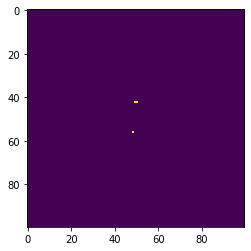

Faulty case : ['none'] 


In [15]:
if MAKE_DATASET:
    # plot 1st data
    plt.imshow(x[0,50:150, 50:150, 0])
    plt.show()

    # check faulty case
    print('Faulty case : {} '.format(faulty_case[y[0]]))

- 14366枚の26x26ウエハの不良パターンは上記のようになっている．

In [16]:
if MAKE_DATASET:
    del df, sw, df_nonpattern, df_withlabel, df_withpattern

- new_xを(14366, 26, 26, 3)とし，最後の次元にはウエハの値(0, 1, 2)がそれぞれの値毎にベクトルとしてまとめられている．

In [17]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|       ImageDataGenerator|      1064|
|                       In|       272|
|                    Input|       144|
|                    KFold|      1064|
|          KerasClassifier|      1064|
|             MAKE_DATASET|        28|
|                      Out|       248|
|       TRAIN_AUTO_ENCODER|        28|
|        auto_encoder_path|        66|
|                     copy|        88|
|                    count|        28|
|          cross_val_score|       144|
|                      csv|        88|
|                      cv2|        88|
|                 datapath|        59|
|                   device|        80|
|                  dirname|        57|
|              encord_size|        28|
|                     exit|        64|
|                        f|        85|
|             failure_list|       144|
|              faulty_case|       420|
|                 filename|        58|
|                filename

In [18]:
# 3チャネルに拡張できない場合
if MAKE_DATASET:
    joblib.dump(x, './data/multi_' + str(max_size) + '/x_multi.pickle')
    
# if not MAKE_DATASET:
#     x = joblib.load('./data/multi_' + str(max_size) + '/x_multi.pickle')

In [19]:
if MAKE_DATASET:
    joblib.dump(y, './data/multi_' + str(max_size) + '/y_multi.pickle')
    
# if not MAKE_DATASET:
#     y = joblib.load('./data/multi_' + str(max_size) + '/y_multi.pickle')

In [20]:
if MAKE_DATASET:
    print(x.shape)
    print(y.shape)
    for i in range(9) :
        print('{} : {}'.format(i, len(y[y==i])))

(172939, 200, 200, 1)
(172939, 1)
0 : 4292
1 : 555
2 : 5189
3 : 9677
4 : 3590
5 : 149
6 : 866
7 : 1190
8 : 147431


### かぶりの除去

In [21]:
# pattern_num_for_dim = []
# for i in pattern_num_list:
#     if i == 0:
#         continue
#     pattern_num_for_dim.extend([i-j for j in range(i)])
# len(pattern_num_for_dim)

In [22]:
# # かぶっているものを特定する
# count = 0
# no = 0
# duplicate_list = []
# for i in range(0, x.shape[0]):
#     if i % 5000 == 0:
#         print(i)
#         print(count)
#         print(no)
#         print(duplicate_list)
#     dup = 0
#     for j in range(i+1, i+pattern_num_for_dim[i]):
#         if x[i, encord_size, encord_size] != x[j, encord_size, encord_size]:
#             continue
#         if np.array_equal(x[i], x[j]):
#             count += 1
#             dup += 1
#             if y[i][0] != y[j][0]:  
#                 no += 1
#                 print(str(i) + ":" + str(y[i][0]) + ", " + str(j) + ":" + str(y[j][0]))
# #                 plt.imshow(x[i])
# #                 plt.show()
#             else:
#                 duplicate_list.append(j)
#     if dup > 1:
#         print(f"dup: {i}")

# print(count)
# print(no)
# print(duplicate_list)

- 重複しているウエハ（同じラベル）
    - `duplicate_list`
- 異なるラベル付けがされた重複しているウエハ14枚に対し，残すものをピックアップ
    - 24433:none
    - 30828:Edge-Loc
    - 34759:Edge-Loc
    - 25971:Center
    - 33768:Loc
    - 34871Edge-Loc
    - 35321:Edge-Loc
    - 28496:none
    - 28889:Edge-Loc
    - 33590:Loc
    - 32891:Loc
    - 34827:Edge-Loc
    - 33021:Edge-Loc
    - 35229:Edge-Loc
- 残さないものはdupulicate_listに追加
    - [31990, 25144, 25847, 34510, 26471, 27132, 27580, 34896, 33296, 29028, 29389, 29696, 29926, 30106]

In [23]:
if MAKE_DATASET:
    duplicate_list = [32768, 32771, 32772, 32777, 32779, 32780, 32783, 32785, 32786, 32787, 32789, 32792, 32794, 32797, 32799, 32800, 32801, 32805, 32806, 32808, 32813, 32814, 32815, 32816, 32817, 32820, 32821, 32825, 32826, 32827, 32828, 32830, 32831, 32832, 32835, 32837, 32839, 32840, 32841, 32842, 32844, 32845, 32850, 32851, 32852, 32854, 32855, 32856, 32857, 32860, 32863, 32865, 32866, 32867, 32871, 32873, 32874, 32881, 32883, 32885, 32887, 32888, 32889, 32892, 32894, 32896, 32897, 32898, 32899, 32900, 32902, 32903, 32904, 32907, 32908, 32910, 32911, 32916, 32917, 32925, 32926, 32928, 32929, 32930, 32931, 32932, 32933, 32934, 32936, 32938, 32939, 32941, 32943, 32944, 32946, 32947, 32948, 32950, 32951, 32952, 32954, 32955, 32956, 32958, 32959, 32960, 32961, 32963, 32964, 32966, 32968, 32970, 32972, 32973, 32977, 32978, 32979, 32980, 32981, 32983, 32985, 32987, 32988, 32991, 32993, 32995, 32998, 32999, 33001, 33003, 33004, 33005, 33007, 33008, 33010, 33013, 33015, 33016, 33019, 33020, 33024, 33026, 33029, 33030, 33031, 33032, 33033, 164106, 164107, 164108, 164109, 33038, 164110, 164111, 164112, 33042, 33043, 33044, 164113, 33046, 164115, 164116, 33049, 33050, 33051, 33052, 164117, 164118, 33055, 164119, 164120, 33058, 164122, 33060, 33061, 33062, 33063, 33064, 33065, 33066, 33067, 33069, 33072, 33075, 33076, 164150, 33079, 33080, 33081, 33083, 33084, 33085, 33087, 33088, 33091, 33092, 33093, 33094, 33095, 33096, 33098, 33101, 33104, 33107, 33108, 33111, 33116, 33117, 33124, 33125, 33126, 33127, 33128, 33129, 33133, 33134, 33137, 33141, 33142, 33144, 33145, 33147, 33148, 33150, 33153, 33157, 33158, 33160, 33162, 33164, 33165, 33168, 33171, 33177, 33179, 33180, 33182, 33184, 33185, 33187, 33188, 33189, 33191, 33194, 33196, 33197, 33199, 33200, 33201, 33203, 33204, 33205, 33206, 33209, 33210, 33211, 33213, 33214, 33217, 33219, 33223, 33226, 33229, 33231, 33232, 33233, 33234, 33236, 33239, 33240, 33242, 33243, 33244, 33245, 33247, 33248, 33249, 33254, 33256, 33259, 33260, 33262, 33263, 33265, 33266, 33268, 33269, 33271, 33274, 33275, 33278, 33279, 33280, 33281, 33284, 33285, 33286, 33287, 33288, 33289, 33290, 33291, 33292, 33294, 33297, 33299, 33301, 33302, 33303, 33304, 33308, 33309, 33310, 33312, 33313, 33314, 33316, 33317, 33318, 33319, 33320, 33322, 33323, 33324, 33326, 33327, 33328, 33329, 33330, 33333, 33334, 33335, 33337, 33338, 33341, 33342, 33344, 33345, 33346, 33347, 33350, 33351, 33358, 33363, 33367, 33369, 33370, 33374, 33375, 33379, 33380, 33382, 33383, 33384, 33385, 33391, 33392, 33393, 33397, 33399, 33404, 33406, 33410, 33411, 33412, 33416, 33417, 33418, 33419, 33420, 33421, 33423, 33425, 33426, 33429, 33431, 33432, 33435, 33437, 33439, 33441, 33443, 33445, 33446, 33448, 33450, 33451, 33452, 33453, 33454, 33456, 33458, 33459, 33462, 33463, 33464, 33465, 33466, 33467, 33468, 33469, 33473, 33475, 33479, 33482, 33484, 33486, 33488, 33490, 33492, 33493, 33494, 33499, 33500, 33506, 33507, 33508, 33509, 33512, 33514, 33515, 33516, 33517, 33518, 33519, 33520, 33521, 33523, 33526, 33528, 33532, 33533, 33534, 33536, 33537, 33538, 33539, 33540, 33541, 33544, 33548, 33549, 33550, 33553, 33554, 33556, 33557, 33562, 33563, 33564, 33565, 33569, 33570, 33572, 33573, 33574, 33579, 33582, 33583, 33584, 33585, 33589, 33591, 33595, 33597, 33599, 33601, 33603, 33605, 33607, 33610, 33611, 33612, 33617, 33618, 33619, 33622, 33628, 33629, 33630, 33632, 33635, 33636, 33637, 33638, 33639, 33641, 33642, 33645, 33647, 172915, 33652, 33653, 33660, 33661, 33663, 33664, 33665, 33670, 33673, 33674, 33677, 33678, 33679, 33681, 33684, 33685, 33686, 33687, 33688, 33689, 33690, 33691, 33692, 33693, 33694, 33697, 33699, 33700, 33701, 33705, 33706, 33713, 33714, 33716, 33717, 33718, 33719, 33725, 33726, 33730, 33733, 33734, 33736, 33740, 33741, 33743, 33744, 33747, 33748, 33750, 33751, 33753, 33754, 33755, 33757, 33758, 33760, 33761, 33762, 33763, 33764, 33770, 33771, 33772, 33773, 33774, 33777, 33779, 33781, 33783, 33784, 33785, 33787, 33790, 33794, 33796, 33797, 33798, 33799, 33803, 33804, 33809, 33811, 33812, 33816, 33817, 33818, 33822, 33823, 33825, 33827, 33828, 33831, 33833, 33834, 33835, 33839, 33842, 33847, 33848, 33849, 33850, 33852, 33853, 33854, 33855, 33858, 33859, 33860, 33861, 33864, 33865, 33866, 33868, 33869, 33871, 33872, 33874, 33878, 33879, 33880, 33881, 33882, 33883, 33884, 33886, 33887, 33888, 33890, 33892, 33893, 33895, 33898, 33899, 33901, 33902, 33903, 33904, 33906, 33907, 33909, 33911, 33916, 33918, 33920, 33921, 33922, 33925, 33928, 33929, 33930, 33934, 33936, 33937, 33938, 33940, 33941, 33942, 33943, 33945, 33948, 33949, 33953, 33954, 33955, 33960, 33961, 33966, 33968, 33971, 33973, 33974, 33977, 33979, 33981, 33982, 33985, 33986, 33987, 33989, 33990, 33992, 33994, 33995, 33996, 33997, 34000, 34001, 34003, 34004, 34006, 34007, 34008, 34010, 34013, 34015, 34018, 34019, 34021, 34022, 34026, 34029, 34033, 34034, 34035, 34036, 34038, 34041, 34042, 34043, 34048, 34050, 34051, 34052, 34053, 34056, 34057, 34060, 34061, 34063, 34065, 34066, 34069, 34071, 34073, 34076, 34077, 34079, 34080, 34081, 34083, 34085, 34086, 34093, 34094, 34095, 34096, 34100, 34102, 34103, 34104, 34105, 34106, 34107, 34109, 34111, 34112, 34115, 34116, 34118, 34119, 34120, 34123, 34124, 34125, 34126, 34129, 34130, 34132, 34136, 34137, 34139, 34140, 34141, 34142, 34143, 34147, 34150, 34152, 34153, 34155, 34156, 34158, 34159, 34161, 34162, 34164, 34165, 34166, 34167, 34168, 34170, 34172, 34173, 34174, 34175, 34176, 34178, 34180, 34181, 34182, 34184, 34185, 34188, 34189, 34191, 34193, 34194, 34195, 34197, 34201, 34203, 34211, 34212, 34213, 34214, 34220, 34221, 34222, 34223, 34225, 34227, 34228, 34229, 34233, 34234, 34237, 34238, 34239, 34240, 34241, 34242, 34243, 34245, 34247, 34248, 34250, 34253, 34254, 34257, 34258, 34259, 34260, 34266, 34267, 34268, 34269, 34270, 34271, 34272, 34273, 34275, 34276, 34277, 34281, 34283, 34285, 34286, 34287, 34288, 34290, 34293, 34296, 34298, 34299, 34301, 34302, 34304, 34305, 34307, 34308, 34310, 34312, 34316, 34318, 34322, 34323, 34325, 34327, 34331, 34333, 34334, 34339, 34343, 34344, 34345, 34346, 34348, 34349, 34350, 34361, 34362, 34365, 34366, 34368, 34369, 34370, 34371, 34372, 34376, 34379, 34384, 34388, 34390, 34391, 34393, 34397, 34399, 34400, 34401, 34402, 34403, 34405, 34410, 34416, 34418, 34421, 34425, 34429, 34430, 34431, 34434, 34435, 34436, 34437, 34439, 34442, 34443, 34444, 34446, 34447, 34448, 34449, 34451, 34455, 34458, 34459, 34460, 34461, 34462, 34463, 34464, 34466, 34468, 34469, 34470, 34473, 34476, 34478, 34480, 34490, 34491, 34495, 34500, 34501, 34502, 34503, 34505, 34508, 34509, 34511, 34514, 34515, 34516, 34520, 34522, 34523, 34524, 34525, 34526, 34528, 34530, 34533, 34535, 34536, 34537, 34539, 34541, 34543, 34545, 34549, 34550, 34555, 34556, 34558, 34559, 34560, 34565, 34566, 34567, 34568, 34569, 34571, 34573, 34575, 34576, 34578, 34582, 34585, 34591, 34593, 34594, 34595, 34597, 34598, 34599, 34600, 34603, 34604, 34605, 34606, 34610, 34611, 34612, 34613, 34614, 34615, 34618, 34619, 34621, 34622, 34626, 34628, 34629, 34630, 34633, 34634, 34635, 34637, 34638, 34639, 34640, 34646, 34647, 34648, 34649, 34652, 34654, 34656, 34659, 34662, 34663, 34665, 34666, 34670, 34674, 34677, 34678, 34679, 34681, 34682, 34683, 34684, 34685, 34687, 34690, 34691, 34692, 34694, 34703, 34709, 34711, 34713, 34716, 34718, 34722, 34724, 34726, 34727, 34731, 34733, 34734, 34735, 34736, 34740, 34742, 34743, 34744, 34746, 34747, 34748, 34750, 34754, 34756, 34757, 34758, 34762, 34765, 34766, 34768, 34770, 34771, 34775, 34776, 34777, 34780, 34781, 34784, 34785, 34788, 34790, 34791, 34798, 34800, 34801, 34802, 34804, 34805, 34806, 34807, 34808, 34810, 34812, 34814, 34817, 34818, 34820, 34821, 34822, 34823, 34824, 34826, 34829, 34832, 34834, 34836, 34838, 34839, 34840, 34842, 34844, 34846, 34848, 34851, 34853, 34854, 34855, 34857, 34860, 34862, 34864, 34865, 34866, 34867, 34868, 34869, 34875, 34878, 34879, 34883, 34884, 34885, 34886, 34888, 34889, 34890, 34892, 34898, 34903, 34906, 34907, 34910, 34912, 34913, 34921, 34924, 34925, 34927, 34929, 34930, 34931, 34932, 34934, 34936, 34937, 34938, 34940, 34941, 34943, 34945, 34948, 34950, 34953, 34954, 34956, 34957, 34959, 34960, 34968, 34974, 34975, 34976, 34977, 34978, 34979, 34981, 34983, 34987, 34988, 34990, 34993, 34994, 34996, 34998, 34999, 35000, 35002, 35003, 35004, 35009, 35011, 35013, 35014, 35015, 35016, 35017, 35020, 35022, 35030, 35032, 35034, 35036, 35037, 35039, 35041, 35043, 35047, 35051, 35052, 35053, 35057, 35061, 35069, 35070, 35071, 35073, 35076, 35078, 35083, 35084, 35085, 35086, 35088, 35089, 35090, 35093, 35094, 35095, 35097, 35099, 35100, 35102, 35103, 35104, 35108, 35109, 35111, 35112, 35113, 35114, 35115, 35117, 35120, 35121, 35122, 35123, 35125, 35126, 35127, 35129, 35131, 35133, 35134, 35135, 35136, 35138, 35142, 35143, 35145, 35146, 35149, 35150, 35152, 35153, 35154, 35157, 35158, 35159, 35161, 35162, 35163, 35164, 35165, 35167, 35168, 35169, 35170, 35176, 35177, 35183, 35191, 35194, 35196, 35199, 35204, 35206, 35219, 35220, 35222, 35223, 35224, 35225, 35230, 35231, 35232, 35234, 35235, 35240, 35242, 35243, 35244, 35245, 35246, 35247, 35248, 35249, 35253, 35256, 35257, 35258, 35259, 35260, 35263, 35264, 35265, 35266, 35267, 35268, 35269, 35272, 35273, 35276, 35278, 35281, 35282, 35284, 35287, 35288, 35289, 35291, 35292, 35294, 35295, 35296, 35298, 35299, 35300, 35302, 35303, 35306, 35309, 35310, 35311, 35312, 35313, 35316, 35322, 35323, 35324, 35325, 35326, 35328, 35329, 35337, 35338, 35339, 35340, 35344, 35345, 35346, 35347, 35348, 35349, 35351, 35352, 35354, 35356, 35358, 35360, 35362, 35364, 35365, 35366, 35368, 35370, 35371, 35374, 35378, 35379, 35380, 35383, 35385, 35386, 35388, 35390, 35392, 35397, 35400, 35402, 35407, 35408, 35409, 35410, 35411, 35413, 35414, 43605, 35416, 35417, 35418, 35419, 35424, 35425, 35429, 35431, 35432, 35434, 35436, 35438, 35441, 35442, 35443, 35445, 35446, 35448, 35450, 35451, 35454, 35456, 35458, 35460, 35461, 35464, 35466, 35470, 35473, 35474, 35477, 35478, 35480, 35482, 35483, 35488, 35489, 35494, 35496, 35497, 35498, 35500, 35501, 35503, 35504, 35510, 35512, 35516, 35517, 35523, 35527, 35530, 35532, 35533, 35535, 35536, 35537, 35538, 35543, 35544, 35545, 35549, 35551, 35552, 35554, 35555, 35557, 35562, 35563, 35565, 35567, 35568, 35571, 35573, 35575, 35577, 35578, 35579, 35581, 35582, 35583, 35584, 35585, 35586, 35588, 35589, 35590, 35592, 35595, 35596, 35597, 35598, 35599, 35600, 35601, 35605, 35606, 35607, 35612, 35614, 35617, 35618, 35619, 35622, 35624, 35625, 35630, 35631, 35633, 35635, 35637, 35638, 35640, 35644, 35645, 35646, 35647, 35648, 35652, 35653, 35654, 35655, 35657, 35659, 35662, 35663, 35664, 35665, 35669, 35672, 35674, 35675, 35678, 35679, 35680, 35685, 35686, 35688, 35689, 35692, 35693, 35695, 35696, 35698, 27507, 35699, 35700, 35703, 35705, 35707, 35710, 35713, 35715, 35716, 35717, 35719, 35722, 35725, 35726, 35727, 35730, 35731, 35732, 35734, 35735, 35736, 35739, 35740, 35742, 35743, 35744, 35745, 35746, 35748, 35755, 35759, 35761, 35762, 35763, 35764, 35766, 35768, 35771, 35779, 35780, 35781, 35783, 35784, 35786, 35787, 35793, 35796, 35798, 35799, 35800, 35801, 35802, 35805, 35806, 35807, 35808, 35809, 35810, 35811, 35812, 35813, 35814, 35815, 35816, 35818, 35820, 35821, 35823, 35825, 35826, 35828, 35829, 35831, 35832, 35833, 35834, 35835, 35837, 35838, 35841, 35844, 35847, 35848, 35851, 35853, 35856, 35857, 35859, 35861, 35869, 35870, 35871, 35873, 35876, 35877, 35878, 35879, 35881, 35885, 35886, 35887, 35890, 35891, 35893, 35895, 35896, 35897, 35902, 166975, 35907, 35908, 35909, 35910, 35912, 35914, 35915, 35916, 35918, 35919, 35920, 35921, 35922, 35923, 35924, 35925, 35926, 35927, 35929, 35933, 35934, 35937, 35938, 35939, 35941, 35942, 35943, 35945, 35947, 35948, 35951, 35957, 35958, 35959, 35961, 35962, 35963, 35966, 35967, 35968, 35970, 35972, 35975, 35976, 35977, 35978, 35979, 35981, 35986, 35988, 35989, 35991, 35992, 35996, 35997, 35998, 35999, 36005, 36006, 36009, 36010, 36012, 36014, 36015, 36016, 36017, 36020, 36021, 36022, 36026, 36027, 36029, 36031, 36033, 36034, 36035, 36036, 36037, 36038, 36039, 36040, 36041, 36042, 36045, 36047, 36051, 36052, 36054, 36055, 36058, 36059, 36063, 36064, 36065, 36066, 36070, 36071, 36072, 36074, 36075, 36076, 36079, 36080, 36083, 36084, 36086, 36088, 36089, 36090, 36092, 36093, 36094, 36095, 36097, 36098, 36099, 36101, 36104, 36105, 36109, 36111, 36112, 36115, 36116, 36118, 36119, 36124, 36126, 36128, 36132, 36134, 36144, 36145, 36147, 36148, 36149, 36151, 36152, 36155, 36156, 36159, 36160, 36161, 36164, 36166, 36167, 36168, 36170, 36171, 36173, 36175, 36176, 36177, 36179, 36180, 36181, 36183, 36185, 36186, 36187, 36189, 36190, 36194, 36196, 36198, 36200, 36202, 36205, 36206, 36209, 36212, 36213, 36214, 36215, 36218, 36219, 36220, 36221, 36222, 36223, 36227, 36228, 36229, 36231, 36232, 36233, 36234, 36236, 36238, 36239, 36242, 36245, 36247, 36250, 36253, 36254, 36255, 36256, 36257, 36260, 36262, 36263, 36264, 36265, 36266, 36269, 36271, 36272, 36274, 36275, 36276, 36277, 36279, 36280, 36283, 36284, 36286, 36287, 36288, 36289, 36296, 36302, 36303, 36305, 36306, 36307, 36308, 36311, 36313, 36318, 36319, 36323, 36324, 36326, 36327, 36331, 36333, 36338, 36340, 36341, 36346, 36352, 36353, 36355, 36358, 36360, 36361, 36362, 36364, 36366, 36372, 36373, 36374, 36375, 36379, 36380, 36384, 36385, 36386, 36387, 36388, 36391, 36394, 36395, 36398, 36399, 36400, 36402, 36403, 36404, 36405, 36408, 36410, 36411, 36416, 36418, 36419, 36421, 36424, 36426, 36428, 36430, 36436, 36438, 36440, 36441, 36444, 36447, 36451, 36454, 36455, 36460, 36461, 36463, 36464, 36466, 36467, 36468, 36471, 36474, 36477, 36480, 36481, 36485, 36486, 36488, 36489, 36493, 36496, 36497, 36501, 36502, 36506, 36507, 36509, 36510, 36511, 36514, 36516, 36518, 36520, 36528, 36530, 36531, 36533, 36538, 36539, 36542, 36543, 36545, 36548, 36549, 36553, 36556, 36559, 36561, 36562, 36563, 36564, 36566, 36567, 36569, 36570, 36571, 36573, 36574, 36575, 36577, 36578, 36579, 36580, 36583, 36584, 36586, 36590, 36592, 36593, 36596, 36597, 36598, 36599, 36600, 36601, 36602, 36603, 36605, 36614, 36616, 36617, 36620, 36621, 36622, 36625, 36626, 36627, 36629, 36630, 36631, 36632, 36635, 36636, 36639, 36640, 36641, 36642, 36644, 36646, 36650, 36652, 36654, 36656, 36667, 168328, 62552, 46192, 46197, 46199, 46220, 46224, 46225, 46251, 46255, 46270, 46275, 46279, 46292, 46304, 46317, 46319, 46324, 46329, 46350, 46366, 46373, 46383, 46388, 46406, 46408, 46415, 46417, 46419, 46435, 46440, 46449, 46450, 46451, 46453, 46455, 46474, 46480, 46482, 46483, 46498, 46509, 46510, 46520, 46521, 46522, 46531, 46532, 46534, 46537, 46549, 46552, 46565, 46567, 46570, 46574, 46576, 46578, 46579, 30284, 30307, 30309, 30330, 30339, 79536, 30408, 79580, 30430, 30431, 30450, 30458, 30487, 30542, 30555, 30576, 30586, 30589, 30592, 30593, 30594, 161666, 30598, 30605, 30608, 30612, 30613, 30615, 30617, 30618, 30620, 30622, 30625, 30626, 30633, 30635, 30636, 30638, 30643, 30645, 30647, 30648, 30652, 30654, 30659, 30660, 30661, 30663, 30664, 30665, 30666, 30670, 30675, 30681, 30686, 30690, 30692, 30701, 30703, 30704, 30705, 30708, 161791, 30720, 30721, 30722, 30724, 30726, 30730, 30737, 30741, 30742, 30743, 30746, 30751, 30752, 30754, 30755, 30758, 30759, 30763, 30765, 30769, 30772, 30773, 30775, 30776, 30778, 30780, 30781, 30782, 30783, 30785, 30786, 30788, 30790, 30792, 30795, 30796, 30797, 30799, 30802, 30804, 30805, 30806, 30808, 30809, 30811, 30812, 30815, 30818, 30819, 30820, 30821, 30824, 30825, 30826, 30827, 30831, 30832, 30833, 30835, 30837, 30838, 30839, 30840, 30841, 30842, 30843, 30845, 30846, 30850, 30851, 30853, 30855, 30856, 30857, 30858, 30859, 30862, 30865, 30866, 30868, 30870, 30871, 30872, 30873, 30874, 161942, 30880, 30881, 30882, 30883, 30887, 30888, 30891, 30892, 30893, 30898, 30900, 30901, 30902, 30904, 30907, 30911, 30912, 30915, 30916, 30919, 30920, 30923, 30925, 30928, 162001, 30930, 30932, 30933, 30936, 30938, 30939, 30940, 30941, 30947, 30948, 30951, 30952, 30956, 30958, 30959, 30960, 30963, 30965, 30966, 30969, 30971, 30973, 30975, 30978, 30979, 30980, 30982, 30983, 30984, 30985, 30986, 30989, 30990, 30991, 30993, 30995, 30996, 30997, 31000, 31002, 31004, 31005, 31006, 31007, 31009, 31010, 31013, 31014, 31016, 31017, 31018, 31019, 31024, 31027, 31028, 31029, 31030, 31031, 31032, 31034, 31038, 31039, 31040, 31042, 31045, 31046, 31049, 31053, 31056, 31061, 31062, 31069, 31070, 31071, 31072, 31075, 31078, 31079, 31081, 31083, 31084, 31086, 31088, 31089, 31090, 31093, 31096, 31098, 31099, 31101, 31102, 31103, 31104, 31105, 31106, 31107, 31109, 164121, 31111, 31112, 31113, 31114, 31115, 31117, 31119, 164123, 31123, 31124, 31125, 164124, 31128, 31129, 31130, 164125, 31133, 31134, 164126, 31136, 31137, 31138, 31139, 164127, 31141, 31142, 31143, 31144, 31148, 31149, 31155, 31156, 31159, 31161, 31163, 31164, 31165, 31170, 31173, 31174, 31176, 31179, 31182, 31184, 31185, 31188, 31190, 31191, 31202, 31203, 31204, 31205, 31206, 31207, 31213, 31216, 31218, 31220, 31223, 31227, 31228, 31230, 31231, 31233, 31234, 31238, 31239, 31241, 31246, 31247, 31248, 31249, 31252, 31261, 31263, 31265, 31266, 31267, 31272, 31274, 31275, 31276, 31278, 31279, 31280, 31281, 31282, 31283, 31284, 31285, 31288, 31291, 31293, 31296, 31297, 31299, 31300, 31301, 31303, 31305, 31309, 31310, 31312, 31313, 31314, 31316, 31317, 31318, 31320, 31321, 31325, 31326, 31328, 31330, 31331, 31334, 31335, 31337, 31339, 31340, 31341, 31342, 31343, 31344, 31345, 31346, 31347, 31350, 31351, 31353, 31355, 31356, 31357, 31359, 31360, 31362, 31363, 31365, 31366, 31369, 31371, 31378, 31379, 31381, 31382, 31385, 31386, 31388, 31389, 31392, 31394, 31395, 31396, 31397, 31398, 31400, 31402, 31403, 31405, 31408, 31410, 31411, 31412, 31413, 31414, 31415, 31416, 31417, 31419, 31420, 31421, 31422, 31424, 31429, 31432, 31436, 31437, 31438, 31439, 31442, 31443, 31444, 31445, 31448, 31451, 31452, 31454, 31456, 31458, 31459, 31461, 31462, 31463, 31464, 31466, 31470, 31472, 31474, 31479, 31480, 31481, 31484, 31486, 31488, 31490, 31491, 31495, 31497, 31502, 31503, 31505, 31506, 31508, 31509, 31510, 31513, 31514, 31516, 31519, 31520, 31522, 31524, 31526, 31527, 31530, 31531, 31532, 31536, 31537, 31539, 31542, 31543, 31544, 31547, 31551, 31553, 31554, 31556, 31557, 31559, 31560, 31562, 31563, 31569, 31570, 31575, 31576, 31577, 31578, 31579, 31581, 31582, 31583, 31584, 31586, 31588, 31589, 31590, 31591, 31592, 31593, 31596, 31601, 31602, 31603, 31604, 31605, 31610, 31614, 31615, 31616, 31617, 31618, 31619, 31620, 31621, 31622, 31624, 31625, 31628, 31634, 31635, 31641, 31642, 31646, 31648, 31651, 31656, 31657, 31662, 31665, 31666, 31667, 31670, 31671, 31673, 31674, 31678, 31681, 31687, 31689, 31691, 31692, 31694, 31697, 31699, 31701, 31704, 31705, 31706, 31707, 31708, 31709, 31715, 31716, 31718, 31719, 31720, 31721, 31722, 31723, 31726, 31729, 31731, 31732, 31736, 31739, 31740, 31741, 31742, 31744, 31749, 31754, 31756, 31758, 31759, 31761, 31763, 31767, 31769, 31773, 31777, 31778, 31779, 31780, 31781, 31784, 31785, 31790, 31791, 31793, 31794, 31796, 31798, 31799, 31800, 31806, 31807, 31809, 31810, 31812, 31813, 31814, 31816, 31817, 31818, 31819, 31820, 89165, 31823, 31824, 31826, 31827, 31830, 31832, 31835, 31836, 31837, 31840, 31841, 31844, 31846, 31847, 31848, 31849, 31854, 31857, 31858, 31864, 31866, 31869, 31873, 31875, 31876, 31879, 31882, 31885, 31887, 31888, 31889, 31893, 31895, 31896, 31898, 31900, 31903, 31904, 31912, 31913, 31914, 31915, 31916, 31920, 31922, 31923, 31926, 31928, 31929, 31931, 31932, 31936, 31937, 31938, 31940, 31941, 31942, 31943, 31945, 31946, 31948, 31949, 31950, 31953, 31956, 31957, 31959, 31960, 31963, 31966, 31969, 31970, 31974, 31976, 31977, 31980, 31981, 31983, 31984, 31985, 31987, 31991, 31992, 31993, 31998, 171262, 32000, 32001, 32002, 171266, 32004, 32015, 32016, 32017, 32018, 32019, 32020, 32024, 32025, 32028, 32031, 32032, 32034, 32035, 32036, 32038, 32040, 32041, 32042, 32045, 32046, 32049, 32053, 32055, 32056, 32059, 32063, 32068, 32072, 32074, 32075, 32078, 32083, 32084, 32085, 32087, 32090, 32091, 32092, 32097, 32098, 32099, 32102, 32106, 32108, 32110, 32111, 32114, 32115, 32116, 32117, 32119, 32122, 32124, 32125, 32126, 32128, 32129, 32131, 32133, 32134, 32137, 32138, 32149, 32150, 32151, 32153, 32156, 32157, 32159, 32160, 32162, 32163, 32166, 32168, 32169, 32171, 32174, 32175, 32176, 32178, 32180, 32182, 32186, 32189, 32191, 32193, 32195, 32196, 32197, 32200, 32202, 32204, 32205, 32207, 32209, 32210, 32211, 32212, 32213, 32216, 32220, 32221, 32222, 32223, 32224, 32225, 32226, 32233, 32237, 32238, 32239, 32240, 32241, 32242, 32243, 32245, 32247, 32253, 32254, 32255, 32257, 32258, 32259, 32263, 32264, 32265, 32267, 32269, 32271, 32274, 32275, 32277, 32280, 32281, 32282, 32284, 32286, 32291, 32292, 32293, 32294, 32295, 32297, 32301, 32302, 32305, 32310, 32311, 32312, 32313, 32315, 32316, 32317, 32320, 32323, 32325, 32326, 32328, 32331, 32332, 32333, 32334, 32336, 32337, 32338, 32339, 32340, 32341, 32342, 32347, 32349, 32350, 32353, 32354, 32355, 32358, 32359, 32360, 32362, 32364, 32366, 32367, 32369, 32371, 32372, 32375, 32377, 32379, 32383, 32384, 32385, 32387, 32390, 32393, 32396, 32397, 32398, 32399, 32404, 32405, 32412, 32413, 32415, 32417, 32423, 32424, 32425, 32427, 32430, 32431, 32432, 32433, 32435, 32436, 32437, 32438, 32440, 32444, 32445, 32446, 32448, 32454, 32456, 32458, 32459, 32460, 32461, 32465, 32466, 32469, 32471, 32475, 32476, 32477, 32478, 32483, 32484, 32488, 32489, 32490, 32492, 32497, 32498, 32499, 32501, 32508, 32510, 32511, 32512, 32513, 32514, 32515, 32516, 32517, 32518, 32519, 32520, 32521, 32522, 32524, 32525, 32526, 32527, 32531, 32532, 32533, 32537, 32539, 32540, 32543, 32545, 32546, 32549, 32550, 32551, 32552, 32553, 32555, 32556, 32557, 32558, 32561, 32563, 32564, 32566, 32568, 32573, 32576, 32578, 32579, 32581, 32584, 32586, 32587, 32588, 32589, 32590, 32592, 32593, 32594, 32595, 32598, 32599, 32600, 32601, 32602, 32603, 32606, 32607, 32608, 32609, 32611, 32612, 32613, 32614, 32615, 32616, 32617, 32619, 32620, 32621, 32622, 32623, 32625, 32626, 32629, 32631, 32632, 32635, 32636, 32637, 32641, 32642, 32643, 32644, 32645, 32647, 32648, 32649, 32650, 32651, 32652, 32654, 32656, 32658, 32659, 32661, 32662, 32663, 32664, 32665, 32668, 32671, 32674, 32675, 32677, 32679, 32680, 32682, 32687, 32689, 32692, 32693, 32694, 32695, 32696, 32697, 32699, 32701, 32702, 32704, 32706, 32707, 32708, 32709, 32713, 32714, 32716, 32723, 32724, 32725, 32726, 32727, 32729, 32730, 32731, 32732, 32735, 32738, 32739, 32740, 32741, 32745, 32747, 32748, 32749, 32754, 32755, 32757, 32759, 32761, 32765, 32766]
    duplicate_list.extend([31990, 25144, 25847, 34510, 26471, 27132, 27580, 34896, 33296, 29028, 29389, 29696, 29926, 30106])
    duplicate_list = list(set(duplicate_list))
    print(x.shape)
    print(y.shape)
    duplicate_list.sort()
    no_duplicate_list = [i for i in range(x.shape[0]) if i not in duplicate_list]
    x = x[no_duplicate_list, :, :, :]
    y = y[no_duplicate_list, :]
    print(x.shape)
    print(y.shape)
    del no_duplicate_list

(172939, 200, 200, 1)
(172939, 1)
(169687, 200, 200, 1)
(169687, 1)


### テストデータを分割
705枚をテストデータとする

In [24]:
def rand_ints_nodup(a, b, k):
    ns = []
    while len(ns) < k:
        n = random.randint(a, b)
        if not n in ns:
            ns.append(n)
    return ns

In [25]:
if MAKE_DATASET:
    pattern_testsize = 50
    random.seed(1)
    randlist = np.concatenate([random.sample(list(np.where(y==i)[0]), pattern_testsize) for i in range(9)])

- tempx, tempyにテストデータを分割
- new_x, yからその分を削除

In [26]:
if MAKE_DATASET:
    tempx = x.copy()[randlist, :, :, :]
    tempy = y.copy()[randlist, :]

In [27]:
if MAKE_DATASET:
    new_tempx = np.zeros((len(tempx), max_size, max_size, 3), dtype='int8')
    for w in range(len(tempx)):
            for i in range(max_size):
                for j in range(max_size):
                    new_tempx[w, i, j, int(tempx[w, i, j])] = 1
            print(w)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
if MAKE_DATASET:
    for i in range(9) :
        print('{} : {}'.format(i, len(tempy[tempy==i])))

0 : 50
1 : 50
2 : 50
3 : 50
4 : 50
5 : 50
6 : 50
7 : 50
8 : 50


In [29]:
if MAKE_DATASET:
    x = np.delete(x, randlist, axis=0)
    y = np.delete(y, randlist, axis=0)

In [30]:
if MAKE_DATASET:
    joblib.dump(new_tempx, './data/multi_' + str(max_size) + '/test/xtest.pickle')
    joblib.dump(tempy, './data/multi_' + str(max_size) + '/test/ytest.pickle')
    # joblib.dump(tempx, './data/multi_' + str(max_size) + '_no_data_augmentation/test/xtest.pickle')
    # joblib.dump(tempy, './data/multi_' + str(max_size) + '_no_data_augmentation/test/ytest.pickle')
    del tempx, tempy

### オリジナルの学習データを3チャネルにして保存

In [ ]:
if MAKE_DATASET:
    import time
    from multiprocessing import Pool

    def save_np(file, count):
        np.save('./data/multi_' + str(max_size) + '/original_data/' + str(count), file)

    batch_size = 1000
    start = time.time()
    for count in range(x.shape[0]//batch_size + 1):
        end = (count + 1) * batch_size if x.shape[0] > (count + 1) * batch_size else x.shape[0]
        save_x = np.zeros((end - count * batch_size, max_size, max_size, 3), dtype='int8')
        batch_count = 0
        for batch in range(count * batch_size, end):
    #         print(' ', batch_count)
            for i in range(max_size):
                for j in range(max_size):
                    save_x[batch_count, i, j, int(x[batch, i, j, :])] = 1
            batch_count += 1
        save_xs = [save_x[i] for i in range(save_x.shape[0])]
        args = list(zip(save_xs, list(range(count * batch_size, end))))
        with Pool() as p:
            p.starmap(save_np, args)

        print(count)
        print('elapsed time', time.time()-start)
    joblib.dump(y, './data/multi_' + str(max_size) + '/original_data/y.pickle')

0
elapsed time 18.250386476516724
1
elapsed time 36.59480047225952
2
elapsed time 54.87210249900818
3
elapsed time 73.37209606170654
4
elapsed time 92.36147499084473
5
elapsed time 110.60899877548218
6
elapsed time 128.90209460258484
7
elapsed time 147.5637650489807
8
elapsed time 165.7153353691101
9
elapsed time 184.0353968143463
10
elapsed time 202.48293805122375
11
elapsed time 220.634507894516
12
elapsed time 239.60982942581177
13
elapsed time 257.9968249797821
14
elapsed time 276.2969982624054
15
elapsed time 294.7538800239563
16
elapsed time 313.8748335838318
17
elapsed time 332.10519909858704
18
elapsed time 350.39583945274353
19
elapsed time 368.65016913414
20
elapsed time 386.7918255329132
21
elapsed time 405.13002729415894
22
elapsed time 423.2637448310852
23
elapsed time 441.852858543396
24
elapsed time 460.46034026145935
25
elapsed time 478.9859697818756
26
elapsed time 497.8365752696991
27
elapsed time 516.2006630897522
28
elapsed time 534.6291136741638
29
elapsed time 552

### オートエンコーダで学習

#### データの読み出し

In [32]:
if TRAIN_AUTO_ENCODER:
    # acquire the .npy name
    data_size = len(glob.glob('./data/multi_' + str(max_size) + '/original_data/' + '*.npy'))
    TRAINS = ['./data/multi_' + str(max_size) + '/original_data/' + str(i) + '.npy' for i in range(data_size)]
    x_train = TRAINS

In [33]:
# batchを取得する関数
from multiprocessing import Pool
import time

def load_array(file):
    return np.load(file)

def get_batch(batch_size): 
    global x_train
    SIZE = len(x_train)
    # n_batchs
    n_batchs = SIZE//batch_size + 1
    # for でyield
    i = 0
    start = time.time()
    while (i < n_batchs):
        print("doing", i, "/", n_batchs)
       
        #あるbatchのfilenameの配列を持っておく
        X_batch_name = x_train[(i * batch_size):((i + 1) * batch_size)]

        # filenameにしたがってバッチのtensorを構築
        with Pool() as p:
            arr = p.map(load_array, X_batch_name)
            
        X_batch = np.array(arr).reshape(len(X_batch_name), max_size, max_size, 3)
#         X_batch = np.array([np.load(file)
#                             for file in X_batch_name]).reshape(len(X_batch_name), max_size, max_size, 3)
        i += 1
        print('elapsed time', time.time()-start)
        yield X_batch

#### エンコーダとデコーダのモデルを学習

- モデルの定義をする．

In [37]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

if TRAIN_AUTO_ENCODER:
    with strategy.scope():
        # Encoder
        input_shape = (max_size, max_size, 3)
        input_tensor = Input(input_shape)
        encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

        latent_vector = layers.MaxPool2D()(encode)

        # Decoder
        decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
        decode_layer_2 = layers.UpSampling2D()
        output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

        # connect decoder layers
        decode = decode_layer_1(latent_vector)
        decode = decode_layer_2(decode)

        ae = models.Model(input_tensor, output_tensor(decode))
        ae.compile(optimizer = 'Adam',
                      loss = 'mse',
                     )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


- 層は
    - 入力層
    - 畳み込み層
    - プーリング層
    - 転置畳み込み層
    - アップサンプリング層

- 学習を開始する．
- `new_x`を`new_x`にエンコードしデコードする．

In [38]:
epoch = 2
batch_size = 128
random.seed(1)

In [39]:
if TRAIN_AUTO_ENCODER:
    epoch_train_loss = []
    for ep in range(epoch):
        print("=" * 50)
        print(ep, "/", epoch)
        step_loss = []

        # batch_size=1000でHDDからバッチを取得する
        for X_batch in get_batch(batch_size):
            ae.train_on_batch(X_batch, X_batch)
            score = ae.evaluate(X_batch, X_batch)
            print("batch loss:", score)
            step_loss.append(score)
        print("Train loss", np.mean(step_loss))
        epoch_train_loss.append(np.mean(step_loss))

        shuffle_indices = random.sample(list(range(len(x_train))), len(x_train))
        x_train = [x_train[i] for i in shuffle_indices]
        
    ae.save(auto_encoder_path)
else:
    ae = models.load_model(auto_encoder_path)

0 / 2
doing 0 / 1323
elapsed time 5.078136920928955
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
4/4 [==============================] - 0s 19ms/step - loss: 0.2093
batch loss: 0.2093290239572525
doing 1 / 1323
elapsed time 15.650579690933228
4/4 [==============================] - 0s 19ms/step - loss: 0.1765
batch loss: 0.17653414607048035
doing 2 / 1323
elapsed time 21.55538034439087
4/4 [==============================] - 0s 19ms/step - loss: 0.1453
batch loss: 0.14534178376197815
doing 3 / 1323
elapsed time 26.5726318359375
4/4 [==============================] -

4/4 [==============================] - 0s 19ms/step - loss: 7.9864e-04
batch loss: 0.000798644672613591
doing 52 / 1323
elapsed time 304.00907278060913
4/4 [==============================] - 0s 20ms/step - loss: 8.1924e-04
batch loss: 0.0008192390669137239
doing 53 / 1323
elapsed time 309.54599046707153
4/4 [==============================] - 0s 19ms/step - loss: 8.4272e-04
batch loss: 0.0008427201537415385
doing 54 / 1323
elapsed time 315.1333327293396
4/4 [==============================] - 0s 20ms/step - loss: 8.6123e-04
batch loss: 0.0008612263482064009
doing 55 / 1323
elapsed time 320.59787917137146
4/4 [==============================] - 0s 19ms/step - loss: 7.8677e-04
batch loss: 0.0007867721142247319
doing 56 / 1323
elapsed time 325.87311840057373
4/4 [==============================] - 0s 19ms/step - loss: 8.3461e-04
batch loss: 0.0008346063550561666
doing 57 / 1323
elapsed time 331.2966549396515
4/4 [==============================] - 0s 19ms/step - loss: 7.3366e-04
batch loss: 0.

4/4 [==============================] - 0s 19ms/step - loss: 7.0971e-04
batch loss: 0.0007097069174051285
doing 106 / 1323
elapsed time 602.6640479564667
4/4 [==============================] - 0s 20ms/step - loss: 7.1040e-04
batch loss: 0.0007104018004611135
doing 107 / 1323
elapsed time 607.6236135959625
4/4 [==============================] - 0s 20ms/step - loss: 7.2033e-04
batch loss: 0.0007203262066468596
doing 108 / 1323
elapsed time 613.189436674118
4/4 [==============================] - 0s 19ms/step - loss: 6.8418e-04
batch loss: 0.0006841830327175558
doing 109 / 1323
elapsed time 618.4317667484283
4/4 [==============================] - 0s 19ms/step - loss: 7.0565e-04
batch loss: 0.0007056514732539654
doing 110 / 1323
elapsed time 624.222517490387
4/4 [==============================] - 0s 19ms/step - loss: 6.7576e-04
batch loss: 0.0006757632945664227
doing 111 / 1323
elapsed time 630.0690948963165
4/4 [==============================] - 0s 19ms/step - loss: 6.3042e-04
batch loss: 0

elapsed time 899.1721036434174
4/4 [==============================] - 0s 19ms/step - loss: 6.4684e-04
batch loss: 0.0006468436331488192
doing 160 / 1323
elapsed time 904.2049522399902
4/4 [==============================] - 0s 20ms/step - loss: 6.1164e-04
batch loss: 0.0006116415606811643
doing 161 / 1323
elapsed time 909.291916847229
4/4 [==============================] - 0s 19ms/step - loss: 6.3410e-04
batch loss: 0.0006341018015518785
doing 162 / 1323
elapsed time 914.113007068634
4/4 [==============================] - 0s 19ms/step - loss: 5.7462e-04
batch loss: 0.0005746223032474518
doing 163 / 1323
elapsed time 919.3448231220245
4/4 [==============================] - 0s 20ms/step - loss: 5.9416e-04
batch loss: 0.0005941558629274368
doing 164 / 1323
elapsed time 924.0865631103516
4/4 [==============================] - 0s 19ms/step - loss: 5.9971e-04
batch loss: 0.0005997111438773572
doing 165 / 1323
elapsed time 929.5808329582214
4/4 [==============================] - 0s 19ms/step -

4/4 [==============================] - 0s 19ms/step - loss: 4.4169e-04
batch loss: 0.00044168566819280386
doing 266 / 1323
elapsed time 1505.5785794258118
4/4 [==============================] - 0s 19ms/step - loss: 4.2242e-04
batch loss: 0.00042241893243044615
doing 267 / 1323
elapsed time 1511.296864748001
4/4 [==============================] - 0s 19ms/step - loss: 4.2384e-04
batch loss: 0.00042383582331240177
doing 268 / 1323
elapsed time 1516.8275759220123
4/4 [==============================] - 0s 19ms/step - loss: 4.3288e-04
batch loss: 0.00043287756852805614
doing 269 / 1323
elapsed time 1521.948254585266
4/4 [==============================] - 0s 19ms/step - loss: 4.4234e-04
batch loss: 0.00044233660446479917
doing 270 / 1323
elapsed time 1527.6299347877502
4/4 [==============================] - 0s 20ms/step - loss: 4.3589e-04
batch loss: 0.00043589132837951183
doing 271 / 1323
elapsed time 1533.093099117279
4/4 [==============================] - 0s 20ms/step - loss: 4.5139e-04
ba

4/4 [==============================] - 0s 19ms/step - loss: 2.3787e-04
batch loss: 0.00023787046666257083
doing 372 / 1323
elapsed time 2114.1376893520355
4/4 [==============================] - 0s 19ms/step - loss: 2.5697e-04
batch loss: 0.00025697474484331906
doing 373 / 1323
elapsed time 2119.6795129776
4/4 [==============================] - 0s 20ms/step - loss: 2.8930e-04
batch loss: 0.0002893010387197137
doing 374 / 1323
elapsed time 2126.2478330135345
4/4 [==============================] - 0s 19ms/step - loss: 2.6326e-04
batch loss: 0.00026325759245082736
doing 375 / 1323
elapsed time 2132.194701910019
4/4 [==============================] - 0s 20ms/step - loss: 2.6011e-04
batch loss: 0.0002601054438855499
doing 376 / 1323
elapsed time 2138.4811611175537
4/4 [==============================] - 0s 19ms/step - loss: 2.6530e-04
batch loss: 0.00026529718888923526
doing 377 / 1323
elapsed time 2144.33944272995
4/4 [==============================] - 0s 20ms/step - loss: 2.5623e-04
batch l

4/4 [==============================] - 0s 19ms/step - loss: 1.7314e-04
batch loss: 0.0001731393567752093
doing 478 / 1323
elapsed time 2740.9945907592773
4/4 [==============================] - 0s 20ms/step - loss: 1.6958e-04
batch loss: 0.00016958071500994265
doing 479 / 1323
elapsed time 2746.8933913707733
4/4 [==============================] - 0s 20ms/step - loss: 1.8153e-04
batch loss: 0.00018153169366996735
doing 480 / 1323
elapsed time 2752.806470155716
4/4 [==============================] - 0s 19ms/step - loss: 1.7313e-04
batch loss: 0.00017313439457211643
doing 481 / 1323
elapsed time 2759.590217113495
4/4 [==============================] - 0s 19ms/step - loss: 1.9460e-04
batch loss: 0.00019459523900877684
doing 482 / 1323
elapsed time 2765.399116039276
4/4 [==============================] - 0s 20ms/step - loss: 1.8322e-04
batch loss: 0.0001832227862905711
doing 483 / 1323
elapsed time 2771.6305634975433
4/4 [==============================] - 0s 19ms/step - loss: 1.5835e-04
batc

4/4 [==============================] - 0s 19ms/step - loss: 1.2655e-04
batch loss: 0.00012654985766857862
doing 584 / 1323
elapsed time 3351.5199027061462
4/4 [==============================] - 0s 20ms/step - loss: 1.3214e-04
batch loss: 0.00013214064529165626
doing 585 / 1323
elapsed time 3356.8250930309296
4/4 [==============================] - 0s 19ms/step - loss: 1.3841e-04
batch loss: 0.00013840779138263315
doing 586 / 1323
elapsed time 3362.6241025924683
4/4 [==============================] - 0s 19ms/step - loss: 1.2594e-04
batch loss: 0.0001259390846826136
doing 587 / 1323
elapsed time 3368.192005634308
4/4 [==============================] - 0s 20ms/step - loss: 1.5016e-04
batch loss: 0.0001501595979789272
doing 588 / 1323
elapsed time 3374.2552518844604
4/4 [==============================] - 0s 20ms/step - loss: 1.3031e-04
batch loss: 0.00013030949048697948
doing 589 / 1323
elapsed time 3379.8810572624207
4/4 [==============================] - 0s 19ms/step - loss: 1.3506e-04
ba

4/4 [==============================] - 0s 19ms/step - loss: 1.2046e-04
batch loss: 0.00012046057963743806
doing 690 / 1323
elapsed time 3951.85676074028
4/4 [==============================] - 0s 19ms/step - loss: 1.0376e-04
batch loss: 0.00010376407590229064
doing 691 / 1323
elapsed time 3957.31951379776
4/4 [==============================] - 0s 19ms/step - loss: 1.2044e-04
batch loss: 0.00012044158211210743
doing 692 / 1323
elapsed time 3962.9394125938416
4/4 [==============================] - 0s 19ms/step - loss: 1.1050e-04
batch loss: 0.00011050485773012042
doing 693 / 1323
elapsed time 3968.3985147476196
4/4 [==============================] - 0s 20ms/step - loss: 1.1153e-04
batch loss: 0.00011153056402690709
doing 694 / 1323
elapsed time 3974.0151958465576
4/4 [==============================] - 0s 19ms/step - loss: 1.1324e-04
batch loss: 0.00011324493971187621
doing 695 / 1323
elapsed time 3980.6678500175476
4/4 [==============================] - 0s 19ms/step - loss: 1.2134e-04
bat

4/4 [==============================] - 0s 19ms/step - loss: 8.8684e-05
batch loss: 8.868403529049829e-05
doing 796 / 1323
elapsed time 4548.890917778015
4/4 [==============================] - 0s 19ms/step - loss: 8.6845e-05
batch loss: 8.684463682584465e-05
doing 797 / 1323
elapsed time 4554.0746965408325
4/4 [==============================] - 0s 20ms/step - loss: 8.8778e-05
batch loss: 8.877768414095044e-05
doing 798 / 1323
elapsed time 4559.392199277878
4/4 [==============================] - 0s 19ms/step - loss: 8.6196e-05
batch loss: 8.619563595857471e-05
doing 799 / 1323
elapsed time 4564.295801401138
4/4 [==============================] - 0s 19ms/step - loss: 8.7870e-05
batch loss: 8.786953549133614e-05
doing 800 / 1323
elapsed time 4570.346765995026
4/4 [==============================] - 0s 19ms/step - loss: 1.1481e-04
batch loss: 0.00011480763350846246
doing 801 / 1323
elapsed time 4575.639312744141
4/4 [==============================] - 0s 20ms/step - loss: 9.1673e-05
batch los

elapsed time 4848.830877065659
4/4 [==============================] - 0s 19ms/step - loss: 7.3890e-05
batch loss: 7.388950325548649e-05
doing 850 / 1323
elapsed time 4854.722184896469
4/4 [==============================] - 0s 19ms/step - loss: 7.5689e-05
batch loss: 7.56886147428304e-05
doing 851 / 1323
elapsed time 4860.26349568367
4/4 [==============================] - 0s 19ms/step - loss: 9.8777e-05
batch loss: 9.877687261905521e-05
doing 852 / 1323
elapsed time 4865.867575407028
4/4 [==============================] - 0s 19ms/step - loss: 9.0974e-05
batch loss: 9.097409201785922e-05
doing 853 / 1323
elapsed time 4872.259967327118
4/4 [==============================] - 0s 20ms/step - loss: 7.6327e-05
batch loss: 7.632728375028819e-05
doing 854 / 1323
elapsed time 4877.94282245636
4/4 [==============================] - 0s 19ms/step - loss: 7.4048e-05
batch loss: 7.40475079510361e-05
doing 855 / 1323
elapsed time 4883.455581188202
4/4 [==============================] - 0s 19ms/step - l

elapsed time 5447.743245601654
4/4 [==============================] - 0s 19ms/step - loss: 8.4365e-05
batch loss: 8.436498319497332e-05
doing 957 / 1323
elapsed time 5453.474342107773
4/4 [==============================] - 0s 19ms/step - loss: 7.4124e-05
batch loss: 7.412429840769619e-05
doing 958 / 1323
elapsed time 5459.469482898712
4/4 [==============================] - 0s 20ms/step - loss: 6.8929e-05
batch loss: 6.89285880071111e-05
doing 959 / 1323
elapsed time 5465.063543558121
4/4 [==============================] - 0s 19ms/step - loss: 6.5178e-05
batch loss: 6.517845031339675e-05
doing 960 / 1323
elapsed time 5470.662888765335
4/4 [==============================] - 0s 19ms/step - loss: 6.9069e-05
batch loss: 6.906862108735368e-05
doing 961 / 1323
elapsed time 5476.903591156006
4/4 [==============================] - 0s 20ms/step - loss: 7.2061e-05
batch loss: 7.206056034192443e-05
doing 962 / 1323
elapsed time 5482.695274591446
4/4 [==============================] - 0s 19ms/step 

4/4 [==============================] - 0s 19ms/step - loss: 5.9958e-05
batch loss: 5.995757965138182e-05
doing 1063 / 1323
elapsed time 6053.037673473358
4/4 [==============================] - 0s 19ms/step - loss: 6.7284e-05
batch loss: 6.728449079673737e-05
doing 1064 / 1323
elapsed time 6059.086403369904
4/4 [==============================] - 0s 19ms/step - loss: 6.6051e-05
batch loss: 6.605144881177694e-05
doing 1065 / 1323
elapsed time 6064.746071577072
4/4 [==============================] - 0s 20ms/step - loss: 6.6391e-05
batch loss: 6.639142520725727e-05
doing 1066 / 1323
elapsed time 6070.482206583023
4/4 [==============================] - 0s 19ms/step - loss: 6.3553e-05
batch loss: 6.355316145345569e-05
doing 1067 / 1323
elapsed time 6076.128613233566
4/4 [==============================] - 0s 19ms/step - loss: 6.1093e-05
batch loss: 6.109262903919443e-05
doing 1068 / 1323
elapsed time 6081.867465734482
4/4 [==============================] - 0s 20ms/step - loss: 6.4012e-05
batch

4/4 [==============================] - 0s 20ms/step - loss: 5.1022e-05
batch loss: 5.102220893604681e-05
doing 1169 / 1323
elapsed time 6655.174679994583
4/4 [==============================] - 0s 19ms/step - loss: 5.3027e-05
batch loss: 5.3027095418656245e-05
doing 1170 / 1323
elapsed time 6660.8939645290375
4/4 [==============================] - 0s 19ms/step - loss: 5.6863e-05
batch loss: 5.686331132892519e-05
doing 1171 / 1323
elapsed time 6666.812988042831
4/4 [==============================] - 0s 20ms/step - loss: 5.1144e-05
batch loss: 5.114383020554669e-05
doing 1172 / 1323
elapsed time 6672.0038368701935
4/4 [==============================] - 0s 19ms/step - loss: 4.9398e-05
batch loss: 4.9397545808460563e-05
doing 1173 / 1323
elapsed time 6677.5731546878815
4/4 [==============================] - 0s 20ms/step - loss: 5.2362e-05
batch loss: 5.2362291171448305e-05
doing 1174 / 1323
elapsed time 6683.8828954696655
4/4 [==============================] - 0s 19ms/step - loss: 5.1583e-0

4/4 [==============================] - 0s 20ms/step - loss: 4.3151e-05
batch loss: 4.315085243433714e-05
doing 1275 / 1323
elapsed time 7257.550971508026
4/4 [==============================] - 0s 19ms/step - loss: 4.5357e-05
batch loss: 4.5357446651905775e-05
doing 1276 / 1323
elapsed time 7263.447001457214
4/4 [==============================] - 0s 19ms/step - loss: 4.3745e-05
batch loss: 4.374495620140806e-05
doing 1277 / 1323
elapsed time 7268.735551118851
4/4 [==============================] - 0s 19ms/step - loss: 4.5753e-05
batch loss: 4.575258572003804e-05
doing 1278 / 1323
elapsed time 7274.185261726379
4/4 [==============================] - 0s 20ms/step - loss: 4.4352e-05
batch loss: 4.435165465110913e-05
doing 1279 / 1323
elapsed time 7280.091205120087
4/4 [==============================] - 0s 19ms/step - loss: 4.8022e-05
batch loss: 4.8022353439591825e-05
doing 1280 / 1323
elapsed time 7285.097211837769
4/4 [==============================] - 0s 19ms/step - loss: 4.6630e-05
bat

elapsed time 305.79091119766235
4/4 [==============================] - 0s 19ms/step - loss: 4.0441e-05
batch loss: 4.044102388434112e-05
doing 58 / 1323
elapsed time 311.36555671691895
4/4 [==============================] - 0s 20ms/step - loss: 3.8222e-05
batch loss: 3.822206053882837e-05
doing 59 / 1323
elapsed time 316.9468686580658
4/4 [==============================] - 0s 19ms/step - loss: 3.7803e-05
batch loss: 3.780349652515724e-05
doing 60 / 1323
elapsed time 322.2089936733246
4/4 [==============================] - 0s 20ms/step - loss: 4.5400e-05
batch loss: 4.5400265662465245e-05
doing 61 / 1323
elapsed time 327.45300030708313
4/4 [==============================] - 0s 19ms/step - loss: 4.2499e-05
batch loss: 4.2499050323385745e-05
doing 62 / 1323
elapsed time 332.69240641593933
4/4 [==============================] - 0s 19ms/step - loss: 4.3792e-05
batch loss: 4.379212987259962e-05
doing 63 / 1323
elapsed time 338.17643642425537
4/4 [==============================] - 0s 19ms/ste

batch loss: 3.608875704230741e-05
doing 111 / 1323
elapsed time 602.8283798694611
4/4 [==============================] - 0s 19ms/step - loss: 3.8456e-05
batch loss: 3.845582978101447e-05
doing 112 / 1323
elapsed time 607.8739631175995
4/4 [==============================] - 0s 19ms/step - loss: 4.4138e-05
batch loss: 4.413798524183221e-05
doing 113 / 1323
elapsed time 612.8155913352966
4/4 [==============================] - 0s 19ms/step - loss: 3.6535e-05
batch loss: 3.653475141618401e-05
doing 114 / 1323
elapsed time 617.7559723854065
4/4 [==============================] - 0s 19ms/step - loss: 3.6645e-05
batch loss: 3.6645047657657415e-05
doing 115 / 1323
elapsed time 623.7049679756165
4/4 [==============================] - 0s 19ms/step - loss: 5.8646e-05
batch loss: 5.864589547854848e-05
doing 116 / 1323
elapsed time 628.9093143939972
4/4 [==============================] - 0s 19ms/step - loss: 4.0756e-05
batch loss: 4.0755607187747955e-05
doing 117 / 1323
elapsed time 633.969036102294

4/4 [==============================] - 0s 19ms/step - loss: 4.3966e-05
batch loss: 4.396619988256134e-05
doing 165 / 1323
elapsed time 893.8889605998993
4/4 [==============================] - 0s 19ms/step - loss: 5.1233e-05
batch loss: 5.123281152918935e-05
doing 166 / 1323
elapsed time 899.5030612945557
4/4 [==============================] - 0s 20ms/step - loss: 3.7712e-05
batch loss: 3.771180854528211e-05
doing 167 / 1323
elapsed time 904.7320518493652
4/4 [==============================] - 0s 19ms/step - loss: 3.9495e-05
batch loss: 3.949501842726022e-05
doing 168 / 1323
elapsed time 909.9042081832886
4/4 [==============================] - 0s 20ms/step - loss: 4.7048e-05
batch loss: 4.704805905930698e-05
doing 169 / 1323
elapsed time 915.9159343242645
4/4 [==============================] - 0s 19ms/step - loss: 3.6360e-05
batch loss: 3.636031033238396e-05
doing 170 / 1323
elapsed time 921.7265503406525
4/4 [==============================] - 0s 19ms/step - loss: 3.9109e-05
batch loss:

4/4 [==============================] - 0s 19ms/step - loss: 3.2264e-05
batch loss: 3.226390981581062e-05
doing 271 / 1323
elapsed time 1497.6418061256409
4/4 [==============================] - 0s 19ms/step - loss: 3.0253e-05
batch loss: 3.0252671422204003e-05
doing 272 / 1323
elapsed time 1503.7109112739563
4/4 [==============================] - 0s 20ms/step - loss: 3.1539e-05
batch loss: 3.1538584153167903e-05
doing 273 / 1323
elapsed time 1509.0845875740051
4/4 [==============================] - 0s 19ms/step - loss: 3.4356e-05
batch loss: 3.435602047829889e-05
doing 274 / 1323
elapsed time 1514.9139304161072
4/4 [==============================] - 0s 19ms/step - loss: 2.9301e-05
batch loss: 2.9301158065209165e-05
doing 275 / 1323
elapsed time 1520.6707870960236
4/4 [==============================] - 0s 19ms/step - loss: 2.9064e-05
batch loss: 2.9064322006888688e-05
doing 276 / 1323
elapsed time 1526.7699794769287
4/4 [==============================] - 0s 19ms/step - loss: 3.4687e-05
b

4/4 [==============================] - 0s 20ms/step - loss: 3.5246e-05
batch loss: 3.5246466723037884e-05
doing 377 / 1323
elapsed time 2107.1051585674286
4/4 [==============================] - 0s 19ms/step - loss: 2.6845e-05
batch loss: 2.6844802050618455e-05
doing 378 / 1323
elapsed time 2112.738131761551
4/4 [==============================] - 0s 19ms/step - loss: 2.9127e-05
batch loss: 2.912653872044757e-05
doing 379 / 1323
elapsed time 2118.4160697460175
4/4 [==============================] - 0s 19ms/step - loss: 3.1644e-05
batch loss: 3.164367808494717e-05
doing 380 / 1323
elapsed time 2124.5994017124176
4/4 [==============================] - 0s 20ms/step - loss: 3.0550e-05
batch loss: 3.0550094379577786e-05
doing 381 / 1323
elapsed time 2129.8831584453583
4/4 [==============================] - 0s 20ms/step - loss: 3.5246e-05
batch loss: 3.524643398122862e-05
doing 382 / 1323
elapsed time 2135.160544872284
4/4 [==============================] - 0s 19ms/step - loss: 3.9275e-05
batc

4/4 [==============================] - 0s 19ms/step - loss: 2.6448e-05
batch loss: 2.64482841885183e-05
doing 483 / 1323
elapsed time 2723.490758419037
4/4 [==============================] - 0s 19ms/step - loss: 2.8577e-05
batch loss: 2.857651088561397e-05
doing 484 / 1323
elapsed time 2729.4713649749756
4/4 [==============================] - 0s 19ms/step - loss: 3.0129e-05
batch loss: 3.0128991056699306e-05
doing 485 / 1323
elapsed time 2734.912028312683
4/4 [==============================] - 0s 19ms/step - loss: 3.1613e-05
batch loss: 3.161275526508689e-05
doing 486 / 1323
elapsed time 2740.8145678043365
4/4 [==============================] - 0s 19ms/step - loss: 3.0553e-05
batch loss: 3.055282650166191e-05
doing 487 / 1323
elapsed time 2746.944438934326
4/4 [==============================] - 0s 19ms/step - loss: 2.7302e-05
batch loss: 2.7301543013891205e-05
doing 488 / 1323
elapsed time 2752.9113340377808
4/4 [==============================] - 0s 20ms/step - loss: 3.0041e-05
batch l

4/4 [==============================] - 0s 19ms/step - loss: 2.3602e-05
batch loss: 2.360191683692392e-05
doing 589 / 1323
elapsed time 3332.923794746399
4/4 [==============================] - 0s 19ms/step - loss: 2.3263e-05
batch loss: 2.3263008188223466e-05
doing 590 / 1323
elapsed time 3339.0539212226868
4/4 [==============================] - 0s 19ms/step - loss: 2.5081e-05
batch loss: 2.5081109924940392e-05
doing 591 / 1323
elapsed time 3344.956818342209
4/4 [==============================] - 0s 20ms/step - loss: 2.7206e-05
batch loss: 2.720605698414147e-05
doing 592 / 1323
elapsed time 3349.9716114997864
4/4 [==============================] - 0s 19ms/step - loss: 2.9886e-05
batch loss: 2.988628693856299e-05
doing 593 / 1323
elapsed time 3355.294487476349
4/4 [==============================] - 0s 20ms/step - loss: 2.6647e-05
batch loss: 2.664694511622656e-05
doing 594 / 1323
elapsed time 3360.834671020508
4/4 [==============================] - 0s 19ms/step - loss: 2.6702e-05
batch l

4/4 [==============================] - 0s 20ms/step - loss: 1.9147e-05
batch loss: 1.914731547003612e-05
doing 695 / 1323
elapsed time 3937.1116514205933
4/4 [==============================] - 0s 19ms/step - loss: 3.4859e-05
batch loss: 3.485861816443503e-05
doing 696 / 1323
elapsed time 3942.992214202881
4/4 [==============================] - 0s 19ms/step - loss: 2.5331e-05
batch loss: 2.5331379220006056e-05
doing 697 / 1323
elapsed time 3948.755546569824
4/4 [==============================] - 0s 20ms/step - loss: 2.4971e-05
batch loss: 2.497132845746819e-05
doing 698 / 1323
elapsed time 3954.2677640914917
4/4 [==============================] - 0s 19ms/step - loss: 2.1166e-05
batch loss: 2.1165786165511236e-05
doing 699 / 1323
elapsed time 3960.390440940857
4/4 [==============================] - 0s 20ms/step - loss: 2.2733e-05
batch loss: 2.273253267048858e-05
doing 700 / 1323
elapsed time 3966.2251393795013
4/4 [==============================] - 0s 19ms/step - loss: 3.6639e-05
batch 

4/4 [==============================] - 0s 19ms/step - loss: 2.5962e-05
batch loss: 2.5961766368709505e-05
doing 801 / 1323
elapsed time 4536.054580926895
4/4 [==============================] - 0s 19ms/step - loss: 1.8327e-05
batch loss: 1.8327402358409017e-05
doing 802 / 1323
elapsed time 4541.136161327362
4/4 [==============================] - 0s 20ms/step - loss: 1.8772e-05
batch loss: 1.8772039766190574e-05
doing 803 / 1323
elapsed time 4546.660674333572
4/4 [==============================] - 0s 20ms/step - loss: 2.5696e-05
batch loss: 2.5695602744235657e-05
doing 804 / 1323
elapsed time 4552.402582645416
4/4 [==============================] - 0s 19ms/step - loss: 2.2491e-05
batch loss: 2.2491454728879035e-05
doing 805 / 1323
elapsed time 4557.723396539688
4/4 [==============================] - 0s 19ms/step - loss: 2.0488e-05
batch loss: 2.048841088253539e-05
doing 806 / 1323
elapsed time 4564.19353890419
4/4 [==============================] - 0s 19ms/step - loss: 2.5507e-05
batch l

4/4 [==============================] - 0s 19ms/step - loss: 2.8948e-05
batch loss: 2.894769568229094e-05
doing 907 / 1323
elapsed time 5142.859927415848
4/4 [==============================] - 0s 19ms/step - loss: 1.8013e-05
batch loss: 1.8013341104961e-05
doing 908 / 1323
elapsed time 5148.555698633194
4/4 [==============================] - 0s 20ms/step - loss: 2.4949e-05
batch loss: 2.494905493222177e-05
doing 909 / 1323
elapsed time 5154.650814771652
4/4 [==============================] - 0s 19ms/step - loss: 2.1059e-05
batch loss: 2.1059109712950885e-05
doing 910 / 1323
elapsed time 5160.464566230774
4/4 [==============================] - 0s 20ms/step - loss: 2.3978e-05
batch loss: 2.3977761884452775e-05
doing 911 / 1323
elapsed time 5166.418337583542
4/4 [==============================] - 0s 19ms/step - loss: 2.3644e-05
batch loss: 2.3643908207304776e-05
doing 912 / 1323
elapsed time 5172.421414613724
4/4 [==============================] - 0s 19ms/step - loss: 2.1963e-05
batch loss

4/4 [==============================] - 0s 19ms/step - loss: 1.6640e-05
batch loss: 1.66403224284295e-05
doing 1013 / 1323
elapsed time 5747.610961437225
4/4 [==============================] - 0s 19ms/step - loss: 2.2088e-05
batch loss: 2.208845216955524e-05
doing 1014 / 1323
elapsed time 5752.9091629981995
4/4 [==============================] - 0s 19ms/step - loss: 1.4463e-05
batch loss: 1.446316218789434e-05
doing 1015 / 1323
elapsed time 5758.4967522621155
4/4 [==============================] - 0s 19ms/step - loss: 2.2444e-05
batch loss: 2.2444222850026563e-05
doing 1016 / 1323
elapsed time 5763.792518377304
4/4 [==============================] - 0s 20ms/step - loss: 2.2604e-05
batch loss: 2.2603830075240694e-05
doing 1017 / 1323
elapsed time 5770.154460906982
4/4 [==============================] - 0s 19ms/step - loss: 2.1708e-05
batch loss: 2.170835250581149e-05
doing 1018 / 1323
elapsed time 5775.968783378601
4/4 [==============================] - 0s 19ms/step - loss: 2.7751e-05
ba

4/4 [==============================] - 0s 19ms/step - loss: 1.7920e-05
batch loss: 1.792041803128086e-05
doing 1119 / 1323
elapsed time 6341.552912473679
4/4 [==============================] - 0s 20ms/step - loss: 1.4712e-05
batch loss: 1.4712302800035104e-05
doing 1120 / 1323
elapsed time 6347.524210929871
4/4 [==============================] - 0s 20ms/step - loss: 1.5440e-05
batch loss: 1.543962753203232e-05
doing 1121 / 1323
elapsed time 6353.52067232132
4/4 [==============================] - 0s 19ms/step - loss: 1.7158e-05
batch loss: 1.715791404421907e-05
doing 1122 / 1323
elapsed time 6359.08406996727
4/4 [==============================] - 0s 20ms/step - loss: 2.5330e-05
batch loss: 2.532975486246869e-05
doing 1123 / 1323
elapsed time 6364.802743196487
4/4 [==============================] - 0s 20ms/step - loss: 2.1738e-05
batch loss: 2.1738040231866762e-05
doing 1124 / 1323
elapsed time 6370.359065771103
4/4 [==============================] - 0s 20ms/step - loss: 1.7632e-05
batch

4/4 [==============================] - 0s 19ms/step - loss: 1.7514e-05
batch loss: 1.7513943021185696e-05
doing 1225 / 1323
elapsed time 6950.2936136722565
4/4 [==============================] - 0s 20ms/step - loss: 1.7043e-05
batch loss: 1.7042566469172016e-05
doing 1226 / 1323
elapsed time 6956.230711698532
4/4 [==============================] - 0s 19ms/step - loss: 1.6228e-05
batch loss: 1.6227630112553015e-05
doing 1227 / 1323
elapsed time 6961.9706864356995
4/4 [==============================] - 0s 20ms/step - loss: 2.4999e-05
batch loss: 2.4998593289637938e-05
doing 1228 / 1323
elapsed time 6967.3719165325165
4/4 [==============================] - 0s 19ms/step - loss: 2.2128e-05
batch loss: 2.2128031559986994e-05
doing 1229 / 1323
elapsed time 6973.190894126892
4/4 [==============================] - 0s 19ms/step - loss: 2.2084e-05
batch loss: 2.2084095689933747e-05
doing 1230 / 1323
elapsed time 6978.330924272537
4/4 [==============================] - 0s 20ms/step - loss: 1.4368e

4/4 [==============================] - 0s 20ms/step - loss: 1.6692e-05
batch loss: 1.6691839846316725e-05
doing 1278 / 1323
elapsed time 7256.140473365784
4/4 [==============================] - 0s 19ms/step - loss: 2.9800e-05
batch loss: 2.9799615731462836e-05
doing 1279 / 1323
elapsed time 7261.939163923264
4/4 [==============================] - 0s 20ms/step - loss: 1.8412e-05
batch loss: 1.8411721612210386e-05
doing 1280 / 1323
elapsed time 7267.434251070023
4/4 [==============================] - 0s 19ms/step - loss: 1.9746e-05
batch loss: 1.9746039470192045e-05
doing 1281 / 1323
elapsed time 7272.956239938736
4/4 [==============================] - 0s 19ms/step - loss: 1.9978e-05
batch loss: 1.9978408090537414e-05
doing 1282 / 1323
elapsed time 7278.670090198517
4/4 [==============================] - 0s 19ms/step - loss: 1.8885e-05
batch loss: 1.8884660676121712e-05
doing 1283 / 1323
elapsed time 7284.441181182861
4/4 [==============================] - 0s 20ms/step - loss: 1.8915e-05

In [40]:
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 150, 150, 64)      36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 300, 300, 64)      0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 300, 300, 3)       1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_______________________________________________________

- エンコーダだけのモデルを定義する．

In [41]:
input_shape = (max_size, max_size, 3)
input_tensor = Input(input_shape)
encode = ae.layers[1](input_tensor)
latent_vector = ae.layers[2](encode)

encoder = models.Model(input_tensor, latent_vector)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


- デコーダだけのモデルを定義する．

In [42]:
decoder_input = Input((encord_size, encord_size, 64))
decode = ae.layers[3](decoder_input)
decode = ae.layers[4](decode)
output_tensor = ae.layers[5](decode)

decoder = models.Model(decoder_input, output_tensor)
decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 64)]    0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 150, 150, 64)      36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 300, 300, 64)      0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 300, 300, 3)       1731      
Total params: 38,659
Trainable params: 38,659
Non-trainable params: 0
_________________________________________________________________


In [43]:
# 01に変換する
def convert_float_to_01(wafer):
    width, height, c = wafer.shape
    int_wafer = np.zeros((width, height, c), dtype='int8')
    for i in range(width):
        for j in range(height):
            max_index = np.argmax(wafer[i, j])
            for k in range(3):
                int_wafer[i, j, k] = 1 if k == max_index else 0
    return int_wafer

### データオーギュメンテーション前にそれぞれのラベルで保存

In [44]:
y = joblib.load('./data/multi_' + str(max_size) + '/y_multi.pickle')
for i in range(9) :
    print('{} : {}'.format(i, len(y[y==i])))

0 : 4287
1 : 555
2 : 5159
3 : 9672
4 : 3575
5 : 141
6 : 852
7 : 1182
8 : 144275


In [32]:
MAKE_DATASET = True

In [60]:
none_idx = np.where(y==8)[0][np.random.choice(len(np.where(y==8)[0]), size=110000, replace=False)]
# new_x = np.delete(new_x, none_idx, axis=0)
# y = np.delete(y, none_idx, axis=0)

In [61]:
none_idx

array([  9726,  37312, 139848, ...,  94411,  28145,  21045])

In [35]:
y.shape

(51436, 1)

In [36]:
if MAKE_DATASET:
    for i in range(9):
        new_x_pattern = new_x[np.where(y[:, 0] == i)]
        y_pattern = y[np.where(y[:, 0] == i)]
        split_num = new_x_pattern.shape[0] // 5 + 1
        for j in range(5):
#             joblib.dump(new_x_pattern[split_num*j:split_num*(j+1)], './data/new_xmulti_' + str(max_size) + '_' + str(i) + '_' + str(j) + '.pickle')
#             joblib.dump(y_pattern[split_num*j:split_num*(j+1)], './data/ymulti_' + str(max_size) + '_' + str(i) + '_' + str(j) + '.pickle')
            joblib.dump(new_x_pattern[split_num*j:split_num*(j+1)], './data/new_xmulti_' + str(max_size) + '_no_data_augmentation_' + str(i) + '_' + str(j) + '.pickle')
            joblib.dump(y_pattern[split_num*j:split_num*(j+1)], './data/ymulti_' + str(max_size) + '_no_data_augmentation_' + str(i) + '_' + str(j) + '.pickle')

In [37]:
del new_x

### データオーギュメンテーション

- データオーギュメンテーションを行う関数を定義する．

In [58]:
# shawon = False
# rotation_num = 3
# inversion = False
# pattern_num = 2000 if shawon else 10000
pattern_num = 32000

each_pattern_num = [y[y==i].shape[0] for i in range(9)]
each_pattern_iteration = [pattern_num // each_pattern_num[i] for i in range(8)]
after_augmentation_pattern_num = [each_pattern_num[i] * (each_pattern_iteration[i] + 1) for i in range(8)]
after_augmentation_pattern_num.append(each_pattern_num[8])

In [75]:
print(each_pattern_num)
print(each_pattern_iteration)
print(after_augmentation_pattern_num)

[4287, 555, 5159, 9672, 3575, 141, 852, 1182, 144275]
[7, 57, 6, 3, 8, 226, 37, 27]
[34296, 32190, 36113, 38688, 32175, 32007, 32376, 33096, 144275]


In [71]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, max_size, max_size, 3), dtype='int8')
    int_noised_gen_x = np.zeros_like(wafer, dtype='int8')
    
    # Make wafer until total # of wafer to 2000
    for i in range(each_pattern_iteration[label]):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), encord_size, encord_size, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        for wafer_num in range(noised_gen_x.shape[0]):
            int_noised_gen_x[wafer_num] = convert_float_to_01(noised_gen_x[wafer_num])
        gen_x = np.concatenate((gen_x, int_noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
#     print(label, gen_x.shape)
    
    del encoded_x
    del noised_encoded_x
    del noised_gen_x
    del int_noised_gen_x
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [ ]:
# Augmentation for all faulty case
all_y = np.empty((0, 1))
count = 0

for i in range(y.shape[0]):
    if i in none_idx:
        continue
    new_x_pattern = np.load('./data/multi_' + str(max_size) + '/original_data/' + str(i) + '.npy').reshape(1, max_size, max_size, 3)
    y_pattern = y[i].reshape(1, 1)
    # skip none case
    if y_pattern[0][0] != 8 :
        gen_x, gen_y = gen_data(new_x_pattern, y_pattern[0][0])
        new_x_pattern = np.concatenate((new_x_pattern, gen_x), axis=0)
        y_pattern = np.concatenate((y_pattern, gen_y))
        del gen_x, gen_y

    for j in range(y_pattern.shape[0]):
        np.save('./data/multi_' + str(max_size) + '/train/' + str(count), new_x_pattern[j])
        count += 1
        if count % 100 == 0:
            print(count)
    all_y = np.concatenate((all_y, y_pattern))
        
joblib.dump(all_y, './data/multi_' + str(max_size) + '/train/y.pickle')

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

In [96]:
all_y.shape

(302035, 1)

In [74]:
[all_y[all_y==i].shape[0] for i in range(9)]

[34192, 32190, 36015, 37540, 31833, 32007, 32186, 31808, 34264]

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

In [41]:
# For no data agumentation
all_y = np.empty((0, 1))
count = 0
for i in range(9):
    for k in range(5):
        print(k, ' start')
#         new_x_pattern = joblib.load('./data/new_xmulti_' + str(max_size) + '_' + str(i) + '_' + str(k) + '.pickle')
#         y_pattern = joblib.load('./data/ymulti_' + str(max_size) + '_' + str(i) + '_' + str(k) + '.pickle')
        new_x_pattern = joblib.load('./data/new_xmulti_' + str(max_size) + '_no_data_augmentation_' + str(i) + '_' + str(k) + '.pickle')
        y_pattern = joblib.load('./data/ymulti_' + str(max_size) + '_no_data_augmentation_' + str(i) + '_' + str(k) + '.pickle')
        # skip none case
        if i != 8 :
            print(new_x_pattern.shape)

        for j in range(y_pattern.shape[0]):
#             np.save('./data/multi_' + str(max_size) + '/train/' + str(count), new_x_pattern[j])
            np.save('./data/multi_' + str(max_size) + '_no_data_augmentation/train/' + str(count), new_x_pattern[j])
            count += 1
            if count % 1000 == 0:
                print(count)
        all_y = np.concatenate((all_y, y_pattern))
#         joblib.dump(new_x_pattern, './data/new_xmulti_' + str(max_size) + '_' + str(i) + '_datagen_' + str(pattern_num) + '.pickle')
#         joblib.dump(y_pattern, './data/ymulti_' + str(max_size) + '_' + str(i) + '_datagen_' + str(pattern_num) + '.pickle')
        joblib.dump(new_x_pattern, './data/new_xmulti_' + str(max_size) + '_no_data_augmentation_' + str(i) + '_datagen_' + str(pattern_num) + '.pickle')
        joblib.dump(y_pattern, './data/ymulti_' + str(max_size) + '_no_data_augmentation_' + str(i) + '_datagen_' + str(pattern_num) + '.pickle')
        del new_x_pattern, y_pattern
    
# joblib.dump(all_y, './data/multi_' + str(max_size) + '/train/y.pickle')
joblib.dump(all_y, './data/multi_' + str(max_size) + '_no_data_augmentation/train/y.pickle')

0  start
(794, 100, 100, 3)
1  start
(794, 100, 100, 3)
1000
2  start
(794, 100, 100, 3)
2000
3  start
(794, 100, 100, 3)
3000
4  start
(792, 100, 100, 3)
0  start
(95, 100, 100, 3)
4000
1  start
(95, 100, 100, 3)
2  start
(95, 100, 100, 3)
3  start
(95, 100, 100, 3)
4  start
(90, 100, 100, 3)
0  start
(885, 100, 100, 3)
5000
1  start
(885, 100, 100, 3)
6000
2  start
(885, 100, 100, 3)
7000
3  start
(885, 100, 100, 3)
4  start
(882, 100, 100, 3)
8000
0  start
(1741, 100, 100, 3)
9000
10000
1  start
(1741, 100, 100, 3)
11000
12000
2  start
(1741, 100, 100, 3)
13000
14000
3  start
(1741, 100, 100, 3)
15000
4  start
(1736, 100, 100, 3)
16000
17000
0  start
(588, 100, 100, 3)
18000
1  start
(588, 100, 100, 3)
2  start
(588, 100, 100, 3)
19000
3  start
(588, 100, 100, 3)
4  start
(584, 100, 100, 3)
20000
0  start
(27, 100, 100, 3)
1  start
(27, 100, 100, 3)
2  start
(27, 100, 100, 3)
3  start
(27, 100, 100, 3)
4  start
(22, 100, 100, 3)
0  start
(148, 100, 100, 3)
1  start
(148, 100, 100, 3

['./data/multi_100_no_data_augmentation/train/y.pickle']

In [42]:
print([all_y[all_y==i].shape[0] for i in range(9)])

[3968, 470, 4422, 8700, 2936, 130, 736, 899, 29175]


In [36]:
new_x.size

4080120000

In [37]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (136004, 100, 100, 3), new_y shape : (136004, 1)


In [38]:
for i in range(9) :
    print('{} : {}'.format(i, len(y[y==i])))

0 : 16100
1 : 10902
2 : 18048
3 : 26457
4 : 15000
5 : 10147
6 : 11400
7 : 11016
8 : 16934


In [39]:
new_y = y

- データオーギュメンテーションを行った結果，各不良データごとに2000枚増えた．
- 合計は30707枚となった．

- 不良ラベルのないデータは削除し，枚数を不良ラベルと同程度にする．

In [40]:
# none_idx = np.where(y==8)[0][np.random.choice(len(np.where(y==8)[0]), size=120000, replace=False)]

In [41]:
# new_x = np.delete(new_x, none_idx, axis=0)
# new_y = np.delete(y, none_idx, axis=0)

In [42]:
# print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

In [43]:
# for i in range(9) :
#     print('{} : {}'.format(i, len(new_y[new_y==i])))

- 削除した結果，全体は19707枚となった．

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

In [44]:
# new_y = y

In [45]:
# for i, l in enumerate(faulty_case):
#     new_y[new_y==l] = i

In [46]:
# one-hot-encoding
new_y = to_categorical(new_y)

- 学習データ（学習データと学習時のテストデータ）と最終的なテストデータに分割する．

In [47]:
# new_X=new_x[0:19000]
# new_Y=new_y[0:19000]
# test_x=new_x[19001:19706]
# test_y=new_y[19001:19706]
# test_x.shape
new_X = new_x
new_Y = new_y

- 学習データを学習データと学習時のテストデータに分割する．

In [48]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.1,
                                                    random_state=2019)

In [49]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (122403, 100, 100, 3), y : (122403, 9)
Test x: (13601, 100, 100, 3), y : (13601, 9)


- 学習データ12730枚，テストデータ6270枚．

- モデルの定義を行う．

In [50]:
def create_model():
    with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
                                        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
        input_shape = (max_size, max_size, 3)
        input_tensor = Input(input_shape)

        conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
        conv_2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv_1)
        conv_3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_2)

        flat = layers.Flatten()(conv_3)

        dense_1 = layers.Dense(256, activation='relu')(flat)
        dense_2 = layers.Dense(64, activation='relu')(dense_1)
        output_tensor = layers.Dense(9, activation='softmax')(dense_2)

        model = models.Model(input_tensor, output_tensor)
        model.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [51]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
#results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
#print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

- Cross validiationによる精度は99.10%であった．

- Cross validationなしで学習する．

In [52]:
# del new_x
# del new_X

In [55]:
epoch=30
batch_size=2048
model = create_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [56]:
history = model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         epochs=epoch,
         batch_size=batch_size,
         verbose=1           
         )

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
60/60 [==============================] - 38s 636ms/step - accuracy: 0.5935 - loss: 1.6482 - val_accuracy: 0.8198 - val_loss: 0.5184
Epoch 2/30
60/60 [==============================] - 36s 600ms/step - accuracy: 0.8620 - loss: 0.3911 - val_accuracy: 0.9020 - val_loss: 0.2809
Epoch 3/30
60/60 [==============================] - 35s 583ms/step - accuracy: 0.9356 - loss: 0.1967 - val_accuracy: 0.9442 - val_loss: 0.1640
Epoch 4/30
60/60 [==============================] - 37s 620ms/step - accuracy: 0.9679 - loss: 0.1085 - val_accuracy: 0.9731 - val_loss: 0.0940
Epoch 5/30
60/60 [==============================] - 36s 608ms/step - accuracy: 0.9858 - loss: 0.0561 - val_accuracy: 0.9868 - val_loss: 0.0507
Epoch 6/30
60/60 [==============================] - 37s 620ms/step - accuracy: 0.9837 -

- テストデータで評価．    

In [57]:
score = model.evaluate(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score[1])

426/426 [==============================] - 3s 7ms/step - accuracy: 0.9954 - loss: 0.0183
Testing Accuracy: 0.9954414963722229


- acuurayは99.31%であった．

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [58]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 640000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               163840256 
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1644

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

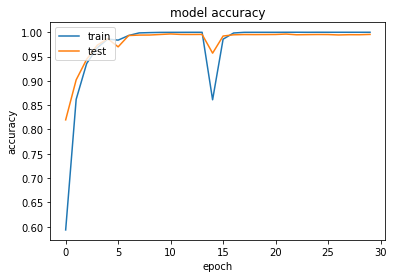

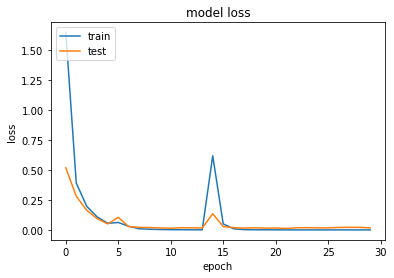

In [59]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()